In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
from src.loaders import *
from src.colocate import *
from src.metrics import *
from src.filter import *
import os
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import pyinterp
import argparse
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian2DKernel

In [2]:
def haversine(lon0, lat0, lon1, lat1):
    r=6371e3
    dphi = np.deg2rad(lat1) - np.deg2rad(lat0)
    dlambda = np.deg2rad(lon1) - np.deg2rad(lon0)
    phi0 = np.deg2rad(lat0)
    phi1 = np.deg2rad(lat1)
    return 2 * r * np.arcsin(np.sqrt((1 - np.cos(dphi) + np.cos(phi0) * np.cos(phi1) * (1 - np.cos(dlambda))) / 2))

def calculate_along_track_dist(ds):
    return haversine(ds['longitude'].values, ds['latitude'].values, np.roll(ds['longitude'].values, 1, axis = 0), np.roll(ds['latitude'].values, 1, axis = 0))

def along_track_filter(ds, scale, filt_type = 'high_pass', filt_vars = 'ssha'):
    
    gauss = Gaussian2DKernel(x_stddev = scale/2e3)
    
    ds['separation_along_track'] = (['num_lines', 'num_pixels'], calculate_along_track_dist(ds))
    break_points = (ds['separation_along_track'] > 2.1e3)
    
    n_lines = ds['num_lines'].values.shape[0]
    
    line_breaks = np.where(break_points.isel(num_pixels = 0, drop = True))[0]
    line_starts = [i + 1 for i in line_breaks if i < n_lines - 1]
    line_ends = [i for i in line_breaks[1:] if i < n_lines]
    line_starts = line_starts[:len(line_ends)]
    
    
    for var in filt_vars:
        print('filtering '+ var)
        ds[var + '_filtered'] = (ds.dims, np.full(ds[var].values.shape, np.nan))
        for segment in range(len(line_starts)):
            print(f'filtering segment {segment}/{len(line_starts)}')
        
            if filt_type == 'high_pass':
                ds[var + '_filtered'][line_starts[segment]:line_ends[segment], :] = ds[var][line_starts[segment]:line_ends[segment], :].values - convolve_fft(ds[var][line_starts[segment]:line_ends[segment], :].values, gauss)
            elif filt_type == 'low_pass':
                ds[var + '_filtered'][line_starts[segment]:line_ends[segment], :] = convolve_fft(ds[var][line_starts[segment]:line_ends[segment], :].values, gauss)
            else:
                raise ValueError("filt_type should be high_pass or low_pass")

    return ds

    

In [96]:
ds = xr.open_dataset('/dat1/smart1n/aviso-data/global training data/duacs/duacs_2019-01-31.nc')
ds2 = xr.open_dataset('/dat1/smart1n/ml_side_projects/GenDA/input_data/cmems_mod_glo_phy_my_0.083deg_P1D-m_multi-vars_70.00W-40.00W_25.00N-45.00N_0.49m_2010-01-01-2020-12-31.nc')
ds3 = xr.open_dataset('/dat1/smart1n/NeurOST_SSH-SST/NeurOST_SSH-SST_20190131_20240507.nc')
ds2['mdt'] = ds2['zos'].mean(dim = 'time')
ds

<xarray.Dataset> Size: 83MB
Dimensions:    (time: 1, latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time       (time) datetime64[ns] 8B 2019-01-31
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    ugos       (time, latitude, longitude) float64 8MB ...
    vgos       (time, latitude, longitude) float64 8MB ...
    vgosa      (time, latitude, longitude) float64 8MB ...
    crs        int32 4B ...
    err_vgosa  (time, latitude, longitude) float64 8MB ...
    sla        (time, latitude, longitude) float64 8MB ...
    ugosa      (time, latitude, longitude) float64 8MB ...
    flag_ice   (time, latitude, longitude) float64 8MB ...
    adt        (time, latitude, longitude) float64 8MB ...
    err_ugosa  (time, latitude, longitude) float64 8MB ...
    err_sla    (time, latitude, longitude) float64 8MB ...
Attributes: (12/45)
    Conventions:                                    CF-1.6
    FROM_ORIGINAL_FILE__Metadata_Conventions:       Unidata Dataset Discovery...
    cdm_data_type:                                  Grid
    comment:                                        Sea Surface Height measur...
    contact:                                        servicedesk.cmems@mercato...
    creator_email:                                  servicedesk.cmems@mercato...
    ...                                             ...
    time_coverage_duration:                         P1D
    time_coverage_end:                              2022-08-04T12:00:00Z
    time_coverage_resolution:                       P1D
    time_coverage_start:                            2022-08-03T12:00:00Z
    title:                                          DT merged all satellites ...
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

In [91]:
ds3['sla'].sel(longitude=slice(295,305),latitude=slice(33,43))[:,:,0]

<xarray.DataArray 'sla' (latitude: 100, longitude: 100)> Size: 40kB
[10000 values with dtype=float32]
Coordinates:
  * longitude               (longitude) float64 800B 295.1 295.2 ... 304.9 305.0
  * latitude                (latitude) float64 800B 33.1 33.2 33.3 ... 42.9 43.0
    time                    datetime64[ns] 8B 2019-01-01
    Lambert_Azimuthal_Grid  int32 4B ...
Attributes:
    long_name:              sea level anomaly
    units:                  m
    description:            SLA mapped using SimVP_SSH_SST_1M_global
    standard_name:          sea_surface_height_above_sea_level
    coverage_content_type:  modelResult
    valid_range:            [-1.e+09  1.e+09]
    grid_mapping:           crs
    comment:                Sea level anomaly mapped using NeurOST (SSH-SST) ...

In [98]:
def vorticity_ssh(x):
    return np.gradient(np.gradient(x)[-2])[-2] + np.gradient(np.gradient(x)[-1])[-1]

ssh_glorys = (ds2['zos'].sel(time='2019-01-31') - ds2['mdt']).sel(longitude=slice(150,160),latitude=slice(20,30)).values
ssh_duacs = ds['sla'].sel(longitude=slice(150,160),latitude=slice(20,30)).values[0,]
ssh_neurost = ds3['sla'].sel(longitude=slice(150,160),latitude=slice(20,30)).values[:,:,0]
vort_glorys = vorticity_ssh(ssh_glorys)/((1/12)/(1/4))**2
vort_duacs = vorticity_ssh(ssh_duacs)
vort_neurost = vorticity_ssh(ssh_neurost)/((1/10)/(1/4))**2


ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

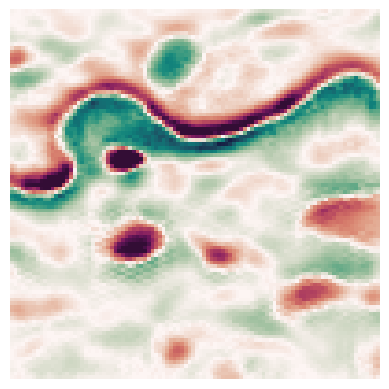

In [93]:
plt.imshow(np.flipud(vort_neurost), cmap = cmocean.cm.curl, vmin = -3e-1, vmax = 3e-1)
plt.axis('off')
plt.savefig('/dat1/smart1n/neurost_vort_panel.png')

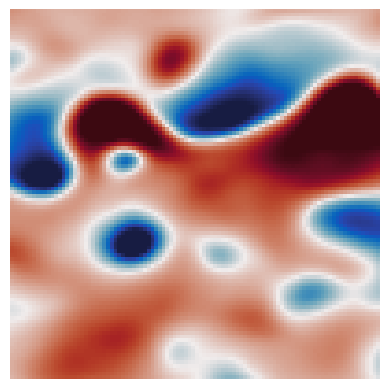

In [94]:
plt.imshow(np.flipud(ssh_neurost), cmap = cmocean.cm.balance, vmin = -0.5, vmax = 0.5)
plt.axis('off')
plt.savefig('/dat1/smart1n/neurost_ssh_panel.png')

In [285]:
from astropy.convolution import Gaussian2DKernel
gauss = Gaussian2DKernel(x_stddev = 1)
data = np.random.randn(100,60) + np.sin(2*np.pi*np.linspace(0,2*np.pi,100)[:,np.newaxis])
data[30:40,] = np.nan
test = convolve(data, gauss)

In [86]:
ds = xr.open_dataset('/dat1/smart1n/SWOT/data/SWOT_L3_LR_SSH_EXPERT_1.0.2/' + os.listdir('/dat1/smart1n/SWOT/data/SWOT_L3_LR_SSH_EXPERT_1.0.2/')[0])
ds

<xarray.Dataset> Size: 80MB
Dimensions:               (num_lines: 9860, num_pixels: 69, num_nadir: 2015)
Coordinates:
    latitude              (num_lines, num_pixels) float64 5MB ...
    longitude             (num_lines, num_pixels) float64 5MB ...
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables: (12/18)
    time                  (num_lines) datetime64[ns] 79kB ...
    calibration           (num_lines, num_pixels) float64 5MB ...
    cross_track_distance  (num_pixels) float64 552B ...
    dac                   (num_lines, num_pixels) float32 3MB ...
    mdt                   (num_lines, num_pixels) float64 5MB ...
    mss                   (num_lines, num_pixels) float64 5MB ...
    ...                    ...
    ugos                  (num_lines, num_pixels) float64 5MB ...
    ugosa                 (num_lines, num_pixels) float64 5MB ...
    vgos                  (num_lines, num_pixels) float64 5MB ...
    vgosa                 (num_lines, num_pixels) float64 5MB ...
    i_num_line            (num_nadir) int16 4kB ...
    i_num_pixel           (num_nadir) int8 2kB ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0 (NASA/CNE...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    geospatial_lon_min:              93.185567
    geospatial_lon_max:              260.131536
    date_modified:                   2024-08-07T20:47:03Z
    history:                         2024-08-07T20:47:03Z: Created by DUACS K...
    date_created:                    2024-08-07T20:47:03Z
    date_issued:                     2024-08-07T20:47:03Z

In [4]:
filt = along_track_filter(interp.ds, 200e3, filt_type = 'high_pass', filt_vars = ['ssha','sla_map'])

filtering ssha
filtering segment 0/28
filtering segment 1/28
filtering segment 2/28
filtering segment 3/28
filtering segment 4/28
filtering segment 5/28
filtering segment 6/28
filtering segment 7/28
filtering segment 8/28
filtering segment 9/28
filtering segment 10/28
filtering segment 11/28
filtering segment 12/28
filtering segment 13/28
filtering segment 14/28
filtering segment 15/28
filtering segment 16/28
filtering segment 17/28
filtering segment 18/28
filtering segment 19/28
filtering segment 20/28
filtering segment 21/28
filtering segment 22/28
filtering segment 23/28
filtering segment 24/28
filtering segment 25/28
filtering segment 26/28
filtering segment 27/28
filtering sla_map
filtering segment 0/28
filtering segment 1/28
filtering segment 2/28
filtering segment 3/28
filtering segment 4/28
filtering segment 5/28
filtering segment 6/28
filtering segment 7/28
filtering segment 8/28
filtering segment 9/28
filtering segment 10/28
filtering segment 11/28
filtering segment 12/28
fil

In [8]:
filt_duacs = along_track_filter(interp_duacs.ds, 200e3, filt_type = 'high_pass', filt_vars = ['ssha','sla_map'])

filtering ssha
filtering segment 0/28
filtering segment 1/28
filtering segment 2/28
filtering segment 3/28
filtering segment 4/28
filtering segment 5/28
filtering segment 6/28
filtering segment 7/28
filtering segment 8/28
filtering segment 9/28
filtering segment 10/28
filtering segment 11/28
filtering segment 12/28
filtering segment 13/28
filtering segment 14/28
filtering segment 15/28
filtering segment 16/28
filtering segment 17/28
filtering segment 18/28
filtering segment 19/28
filtering segment 20/28
filtering segment 21/28
filtering segment 22/28
filtering segment 23/28
filtering segment 24/28
filtering segment 25/28
filtering segment 26/28
filtering segment 27/28
filtering sla_map
filtering segment 0/28
filtering segment 1/28
filtering segment 2/28
filtering segment 3/28
filtering segment 4/28
filtering segment 5/28
filtering segment 6/28
filtering segment 7/28
filtering segment 8/28
filtering segment 9/28
filtering segment 10/28
filtering segment 11/28
filtering segment 12/28
fil

In [57]:
d = filt['sla_map_filtered'].values
d[~np.isnan(d)].shape[0]/d[np.isnan(d)].shape[0]

0.013755691056434476

In [58]:
d = filt['sla_map'].values
d[~np.isnan(d)].shape[0]/d[np.isnan(d)].shape[0]

0.8206544347565864

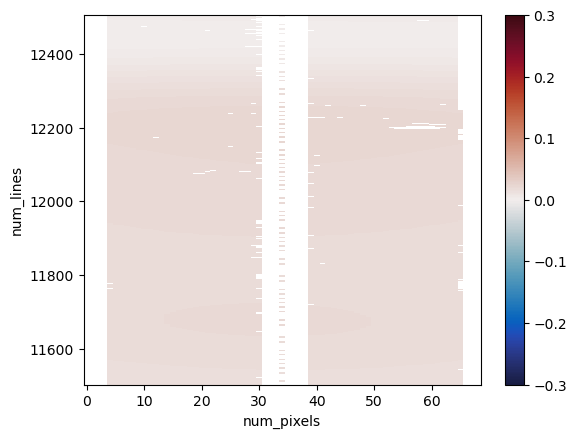

In [85]:
start = 3000
(filt['ssha'] - filt['ssha_filtered']).isel(num_lines = slice(start,start + 1000)).plot(cmap = cmocean.cm.balance, vmin = -0.3, vmax = 0.3)

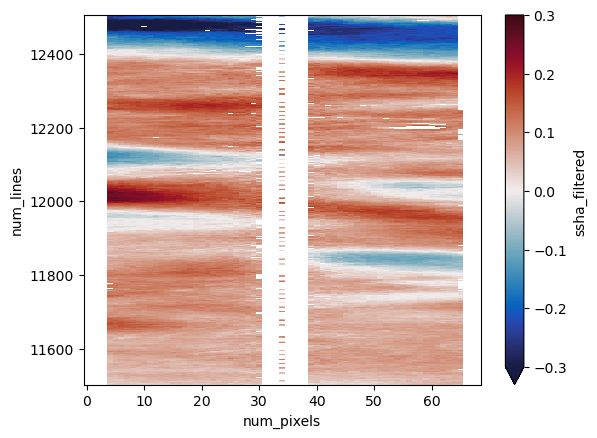

In [83]:
(filt['ssha_filtered']).isel(num_lines = slice(start,start + 1000)).plot(cmap = cmocean.cm.balance, vmin = -0.3, vmax = 0.3)

In [5]:
agg, stats = calc_aggregate_stats(data = filt, single_vars = ['sla_map', 'ssha', 'sla_map_filtered', 'ssha_filtered'], pairwise_vars = [['ssha', 'sla_map'], ['ssha_filtered', 'sla_map_filtered']], lon_bin_size = 5, lat_bin_size = 5)

Binning: sla_map
Binning: ssha
Binning: sla_map_filtered
Binning: ssha_filtered
Binning diff between: ssha and sla_map
Binning diff between: ssha_filtered and sla_map_filtered


In [7]:
agg.data_vars

Data variables:
    sla_map_sum                     (latitude, longitude) float64 22kB 0.0 .....
    sla_map_sum_squares             (latitude, longitude) float64 22kB 0.0 .....
    sla_map_count                   (latitude, longitude) uint64 22kB 0 0 ... 0
    ssha_sum                        (latitude, longitude) float64 22kB 0.0 .....
    ssha_sum_squares                (latitude, longitude) float64 22kB 0.0 .....
    ssha_count                      (latitude, longitude) uint64 22kB 0 0 ... 0
    sla_map_filtered_sum            (latitude, longitude) float64 22kB 0.0 .....
    sla_map_filtered_sum_squares    (latitude, longitude) float64 22kB 0.0 .....
    sla_map_filtered_count          (latitude, longitude) uint64 22kB 0 0 ... 0
    ssha_filtered_sum               (latitude, longitude) float64 22kB 0.0 .....
    ssha_filtered_sum_squares       (latitude, longitude) float64 22kB 0.0 .....
    ssha_filtered_count             (latitude, longitude) uint64 22kB 0 0 ... 0
    ssha_diff_su

In [9]:
agg_duacs, stats_duacs = calc_aggregate_stats(data = filt_duacs, single_vars = ['sla_map', 'ssha', 'sla_map_filtered', 'ssha_filtered'], pairwise_vars = [['ssha', 'sla_map'], ['ssha_filtered', 'sla_map_filtered']], lon_bin_size = 5, lat_bin_size = 5)

Binning: sla_map
Binning: ssha
Binning: sla_map_filtered
Binning: ssha_filtered
Binning diff between: ssha and sla_map
Binning diff between: ssha_filtered and sla_map_filtered


In [104]:
d = ((filt['sla_map_filtered'] - filt['ssha_filtered']) - (filt['sla_map'] - filt['ssha'])).values
d = d[~np.isnan(d)]
d = d[d != 0]
d.shape

(8312393,)

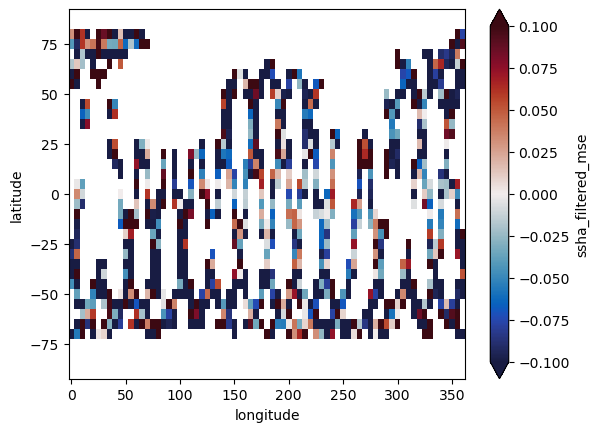

In [14]:
((np.sqrt(stats['ssha_filtered_mse']) - np.sqrt(stats_duacs['ssha_filtered_mse']))/np.sqrt(stats_duacs['ssha_filtered_mse'])).plot(vmin = -0.1, vmax = 0.1, cmap = cmocean.cm.balance)

In [97]:
(np.sqrt(agg['ssha_sum']) - np.sqrt(agg['ssha_filtered_sum'])).values

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.09577645, 1.25487257, 1.20400013, ..., 0.        , 0.14711315,
        1.07493611],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

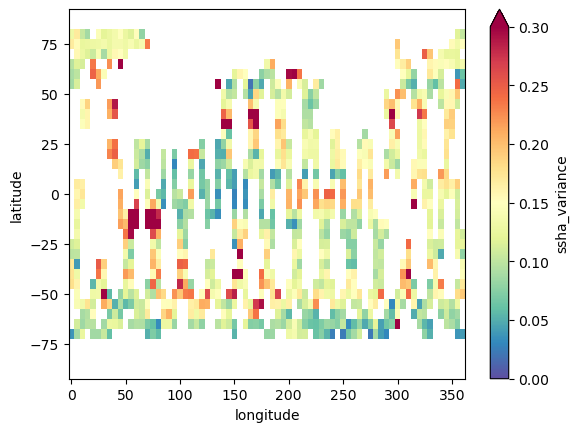

In [90]:
np.sqrt(stats['ssha_variance']).plot(cmap = 'Spectral_r', vmin = 0, vmax = 0.3)

In [35]:
start = 1900 + 1250
data = interp.ds['ssha'].isel(num_lines = slice(start + 1, start + 2000)).values
data_map = interp.ds['sla_map'].isel(num_lines = slice(start + 1, start + 2000)).values
data_duacs = interp_duacs.ds['sla_map'].isel(num_lines = slice(start + 1, start + 2000)).values
# gauss = Gaussian2DKernel(x_stddev = 100e3/2e3)
# filt = convolve_fft(data, gauss)
data.shape

(1999, 69)

In [49]:
from astropy.convolution import Box2DKernel

In [36]:
gauss = Gaussian2DKernel(x_stddev = 200e3/2e3)
filt = convolve_fft(data, gauss)
filt_map = convolve_fft(data_map, gauss)
filt_duacs = convolve_fft(data_duacs, gauss)


In [37]:
print(np.sqrt(np.nanmean(((data - filt) - (data_map - filt_map)) ** 2)))
print(np.sqrt(np.nanmean(((data - filt) - (data_duacs - filt_duacs)) ** 2)))
print(np.sqrt(np.nanmean((filt - filt_map) ** 2)))
print(np.sqrt(np.nanmean((filt - filt_duacs) ** 2)))

0.02311259072526723
0.0266283738580773
0.0009445860924340352
0.0027939967197124524


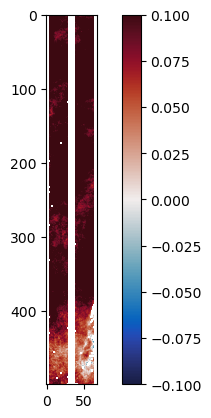

In [30]:
plt.imshow(data[:500,], cmap = cmocean.cm.balance, vmin = -0.1, vmax = 0.1)
plt.colorbar()

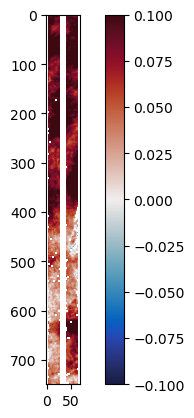

In [31]:
plt.imshow(data[:750,] - filt[:750,], cmap = cmocean.cm.balance, vmin = -0.1, vmax = 0.1)
plt.colorbar()

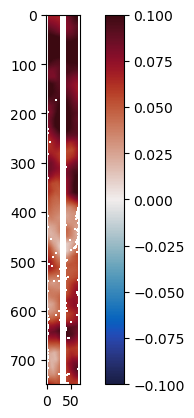

In [32]:
plt.imshow(data_duacs[:750,] - filt_duacs[:750,], cmap = cmocean.cm.balance, vmin = -0.1, vmax = 0.1)
plt.colorbar()

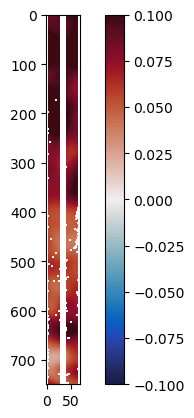

In [33]:
plt.imshow(data_map[:750,] - filt_map[:750,], cmap = cmocean.cm.balance, vmin = -0.1, vmax = 0.1)
plt.colorbar()

In [2]:
%%time
datadir = '/dat1/smart1n/SWOT/data/SWOT_L3_LR_SSH_EXPERT_1.0.2/'
mapdir = '/dat1/smart1n/DUACS_NRT/'
start = np.datetime64("2024-01-01T00:00:00")
end = np.datetime64("2024-01-02T00:00:00")
map_data = Map_L4_Dataset(mapdir, start, end, name_convention = {'prefix': 'nrt_global_allsat_phy_l4_', 
                                                                 'date_hyphenated': False,
                                                                 'suffix_format': '_YYYYMMDD.nc' 
                                                                })
swot_data = SWOT_L3_Dataset(datadir, start, end, file_prefix = 'SWOT_L3_LR_SSH_Expert_XXX_YYY_')
print('starting interpolation')
interp_duacs = interp_L4_to_L3(map_data, swot_data)
# print('starting aggregation')
# if interp is not None:
#     agg, stats = calc_aggregate_stats(data = interp.ds, single_vars = ['sla_map', 'ssha'], pairwise_vars = [['ssha', 'sla_map']], lon_bin_size = 1, lat_bin_size = 1)

Loading file 0 out of 29
Concatenating datasets
Removing times outside window
Data loading complete
starting interpolation
CPU times: user 24.5 s, sys: 14.1 s, total: 38.6 s
Wall time: 51.8 s


In [ ]:
class SWOT_L3_Dataset_debug:
    """
    A dataset for storing SWOT L3 data from all granules between two datetimes, concatenated alon the num_lines axis.

    Attributes:
        data_dir (str): The directory containing SWOT L3 files.
        window_start (np.datetime64): Start datetime of the window to load data from
        window_end (np.datetime64): End datetime of the window to load data from
        
        
    Methods:
        
    """
    
    def __init__(self, datadir, window_start, window_end, keep_vars = ['ssha', 'mdt', 'time', 'quality_flag'], file_prefix = 'SWOT_L3_LR_SSH_Expert_XXX_YYY_', ds = None, bounds = None):
        
        self.datadir = datadir
        self.window_start = window_start
        self.window_end = window_end
        self.keep_vars = keep_vars
        self.file_prefix = file_prefix
        self.bounds = bounds
        
        if ds is None:
        
            files = sorted(os.listdir(datadir))
            files = [f for f in files if '.nc' in f]

            start_dates, end_dates = find_swot_start_end(files, file_prefix)

            files_load = []
            start_dates_load = []

            for i, f in enumerate(files):
                
                if end_dates[i]>window_start and start_dates[i]<window_end:
                    files_load.append(f)
                    start_dates_load.append(window_start)
                elif start_dates[i]>window_start and start_dates[i]<window_end:
                    files_load.append(f)
                    start_dates_load.append(window_start)
                elif end_dates[i]>window_start and end_dates[i]<window_end:
                    files_load.append(f)
                    start_dates_load.append(window_start)

            paths_load = [datadir +'/' + f for f in files_load]
            paths_load = [x for _, x in sorted(zip(start_dates_load, paths_load))]
            # paths_load = sorted(paths_load) # TO DO: fix sorting to sort by datetime rather than file name as they don't necessarily give same answer...
            print(paths_load)
            num_lines_global = 0
            datasets = []
            if len(paths_load) > 0:
                for i, f in enumerate(paths_load):
                    if i % 100 == 0:
                        print(f'Loading file {i} out of {len(files_load)}')
                    ds = xr.open_dataset(f)

                    ds = ds.drop(['i_num_line', 'i_num_pixel'])
                    time_expanded = xr.DataArray(
                                                np.repeat(ds.time.values[:, np.newaxis], ds['num_pixels'].values.shape[0], -1),
                                                dims=('num_lines', 'num_pixels'),
                                                coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
                                            )

                    # Assign the expanded time dimension to the dataset
                    ds['time'] = time_expanded
                    ds['num_lines'] = ds['num_lines'] + num_lines_global
                    num_lines_global += ds['num_lines'].shape[0]
                    datasets.append(ds[keep_vars].load())

                print('Concatenating datasets')
                self.ds = xr.concat(datasets, dim = 'num_lines')

                del datasets
                gc.collect()

                print('Removing times outside window')
                mask_time = ((self.ds['time'] > window_start) & (self.ds['time'] < window_end)).astype('bool')

                self.ds = self.ds.where(mask_time, drop = True).load()

                del mask_time
                gc.collect()
            
            else:
                self.ds = None
            
            print('Data loading complete')
        else:
            self.ds = ds
        
    def subset(self, lon_min = None, lon_max = None, lat_min = None, lat_max = None, time_min = None, time_max = None):
        # longitude masking
        if (lon_min is not None) or (lon_max is not None):
            mask_lon = ((self.ds['longitude'] > lon_min) & (self.ds['longitude'] < lon_max)).astype('bool')
        else:
            mask_lon = xr.DataArray(True, dims=self.ds.dims, coords=self.ds.coords)
        
        # latitude masking
        if (lat_min is not None) or (lat_max is not None):
            mask_lat = ((self.ds['latitude'] > lat_min) & (self.ds['latitude'] < lat_max)).astype('bool')
        else:
            mask_lat = xr.DataArray(True, dims=self.ds.dims, coords=self.ds.coords)
            
        # time masking
        if (time_min is not None) or (time_max is not None):
            mask_time = ((self.ds['time'] > time_min) & (self.ds['time'] < time_max)).astype('bool')
        else:
            mask_time = xr.DataArray(True, dims=self.ds.dims, coords=self.ds.coords)
            
        # total mask by combining all 3:
        
        mask_total = mask_lon & mask_lat & mask_time
    
        bounds = {'lon_min': lon_min, 
                  'lon_max': lon_max, 
                  'lat_min': lat_min,
                  'lat_max': lat_max,
                  'time_min': time_min,
                  'time_max': time_max
                 }
        
        # return another instance of the class but with subset
        return SWOT_L3_Dataset(datadir = self.datadir, 
                              window_start = self.window_start, 
                              window_end = self.window_end,
                              keep_vars = self.keep_vars,
                              file_prefix = self.file_prefix,
                              ds = self.ds.where(mask_total, drop = True),
                              bounds = bounds
                             )
    
    def clone(self):
        # return another instance of the class but with subset
        return SWOT_L3_Dataset(datadir = self.datadir, 
                              window_start = self.window_start, 
                              window_end = self.window_end,
                              keep_vars = self.keep_vars,
                              file_prefix = self.file_prefix,
                              ds = self.ds,
                              bounds = self.bounds
                             )
    
    def add_vars(self, data, var_names):
        for v, name in enumerate(var_names):
            self.ds[name] = data[v]
            
            
    def length(self):
        if self.ds is not None:
            return self.ds['num_lines'].values.shape[0]
        else: 
            return 0

In [8]:
%%time
datadir = '/dat1/smart1n/SWOT/data/SWOT_L3_LR_SSH_EXPERT_1.0.2/'
mapdir = '/dat1/smart1n/NeurOST_SSH-SST/'
start = np.datetime64("2024-01-01T00:00:00")
end = np.datetime64("2024-01-02T00:00:00")
map_data = Map_L4_Dataset(mapdir, start, end)
swot_data = SWOT_L3_Dataset(datadir, start, end, file_prefix = 'SWOT_L3_LR_SSH_Expert_XXX_YYY_')
print('starting interpolation')
interp = interp_L4_to_L3(map_data, swot_data)
# print('starting aggregation')
# if interp is not None:
#     agg, stats = calc_aggregate_stats(data = interp.ds, single_vars = ['sla_map', 'ssha'], pairwise_vars = [['ssha', 'sla_map']], lon_bin_size = 1, lat_bin_size = 1)

Loading file 0 out of 29
Concatenating datasets
Removing times outside window
Data loading complete
starting interpolation
CPU times: user 20.6 s, sys: 12 s, total: 32.7 s
Wall time: 33.4 s


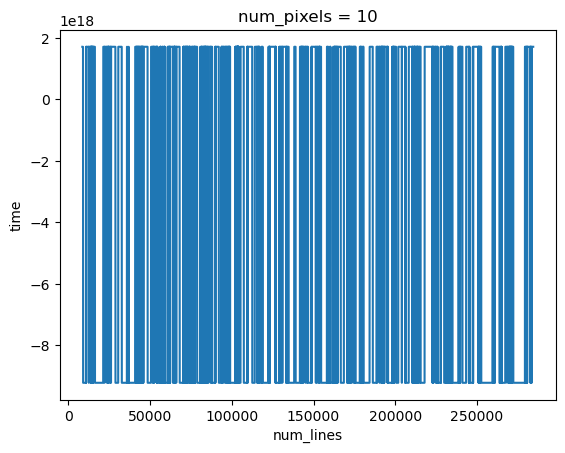

In [15]:
swot_data.ds['time'].isel(num_pixels = 10).astype('float').plot()

In [184]:
d = haversine(subset['longitude'].values, subset['latitude'].values, np.roll(subset['longitude'].values, 1, axis = 0), np.roll(subset['latitude'].values, 1, axis = 0), )

In [297]:
data = subset['ssha'][1:585,:].values
data

KeyboardInterrupt: 

In [294]:
filt = along_track_filter(subset, 100e3, filt_vars = ['ssha'])


filtering segment 0/14


KeyboardInterrupt: 

In [ ]:
filt

In [9]:
map_data.ds
mask = (map_data.ds['sla'].isnull())
map_data.ds.sel(mask)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [16]:
files = os.listdir('/dat1/smart1n/SWOT/data/SWOT_L3_LR_SSH_EXPERT_1.0.2/')
files = [f for f in files if '.nc' in f]
start, end = find_swot_start_end(files, file_prefix = 'SWOT_L3_LR_SSH_Expert_XXX_YYY_')

In [21]:
np.full((2,2), np.nan)

array([[nan, nan],
       [nan, nan]])

In [33]:
map_data = Map_L4_Dataset(mapdir, start, end)

In [9]:
start_date = '2023-11-05'
end_date = '2023-11-15'

# Convert to datetime64 objects
start_dt = np.datetime64(start_date)
end_dt = np.datetime64(end_date)

# Calculate the number of days between the two dates
num_days = (end_dt - start_dt).astype('timedelta64[D]') + 1

# Create an array of dates with the desired spacing
date_array = np.arange(start_dt, end_dt + np.timedelta64(1, 'D'))

print(date_array.astype('datetime64[s]'))

['2023-11-05T00:00:00' '2023-11-06T00:00:00' '2023-11-07T00:00:00'
 '2023-11-08T00:00:00' '2023-11-09T00:00:00' '2023-11-10T00:00:00'
 '2023-11-11T00:00:00' '2023-11-12T00:00:00' '2023-11-13T00:00:00'
 '2023-11-14T00:00:00' '2023-11-15T00:00:00']


In [35]:
swot_data = SWOT_L3_Dataset(datadir, start, end, file_prefix = 'SWOT_L3_LR_SSH_Expert_XXX_YYY_')

In [36]:
%%time
interp = interp_L4_to_L3(map_data, swot_data)

CPU times: user 7.06 s, sys: 1.68 s, total: 8.74 s
Wall time: 8.73 s


In [30]:
subset = interp.subset(lon_min = 295, lon_max = 305, lat_min = 33, lat_max = 43)

/dat1/smart1n/miniconda3/envs/llc4320/lib/python3.12/site-packages/xarray/core/indexing.py:1436: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [16]:
result = xr.open_dataset('results/NeurOST_SSH-SST_filtered.nc')
result_duacs = xr.open_dataset('results/DUACS_filtered.nc')
result

<xarray.Dataset> Size: 360MB
Dimensions:                         (time: 53, lat: 181, lon: 361)
Coordinates:
  * time                            (time) datetime64[ns] 424B 2023-06-01 ......
  * lat                             (lat) float64 1kB -90.0 -89.0 ... 89.0 90.0
  * lon                             (lon) float64 3kB 0.0 1.0 ... 359.0 360.0
Data variables: (12/26)
    ssha_sum                        (time, lat, lon) float32 14MB ...
    ssha_sum_squares                (time, lat, lon) float32 14MB ...
    ssha_count                      (time, lat, lon) float32 14MB ...
    ssha_filtered_sum               (time, lat, lon) float32 14MB ...
    ssha_filtered_sum_squares       (time, lat, lon) float32 14MB ...
    ssha_filtered_count             (time, lat, lon) float32 14MB ...
    ...                              ...
    ssha_mse                        (time, lat, lon) float32 14MB ...
    ssha_R2                         (time, lat, lon) float32 14MB ...
    sla_map_filtered_variance       (time, lat, lon) float32 14MB ...
    ssha_filtered_variance          (time, lat, lon) float32 14MB ...
    ssha_filtered_mse               (time, lat, lon) float32 14MB ...
    ssha_filtered_R2                (time, lat, lon) float32 14MB ...

In [41]:
time_slicer = {'time': slice('2023-0-01', '2024-10-01')}

rmse_neurost = np.sqrt(result['ssha_filtered_diff_sum_squares'].isel(time = slice(3,None)).sum(dim='time')/result['ssha_filtered_diff_count'].isel(time = slice(3,None)).sum(dim='time'))
rmse_duacs = np.sqrt(result_duacs['ssha_filtered_diff_sum_squares'].isel(time = slice(3,None)).sum(dim='time')/result_duacs['ssha_filtered_diff_count'].isel(time = slice(3,None)).sum(dim='time'))
std_neurost = np.sqrt(result['sla_map_filtered_sum_squares'].isel(time = slice(3,None)).sum(dim='time')/result['sla_map_filtered_count'].isel(time = slice(3,None)).sum(dim='time'))
std_duacs = np.sqrt(result_duacs['sla_map_filtered_sum_squares'].isel(time = slice(3,None)).sum(dim='time')/result_duacs['sla_map_filtered_count'].isel(time = slice(3,None)).sum(dim='time'))
std_swot = np.sqrt(result['ssha_filtered_sum_squares'].isel(time = slice(3,None)).sum(dim='time')/result['ssha_filtered_count'].isel(time = slice(3,None)).sum(dim='time'))

# rmse_neurost = np.sqrt(result['ssha_filtered_diff_sum_squares'].sel(time_slicer).sum(dim='time')/result['ssha_filtered_diff_count'].sel(time_slicer).sum(dim='time'))
# rmse_duacs = np.sqrt(result_duacs['ssha_filtered_diff_sum_squares'].sel(time_slicer).sum(dim='time')/result_duacs['ssha_filtered_diff_count'].sel(time_slicer).sum(dim='time'))

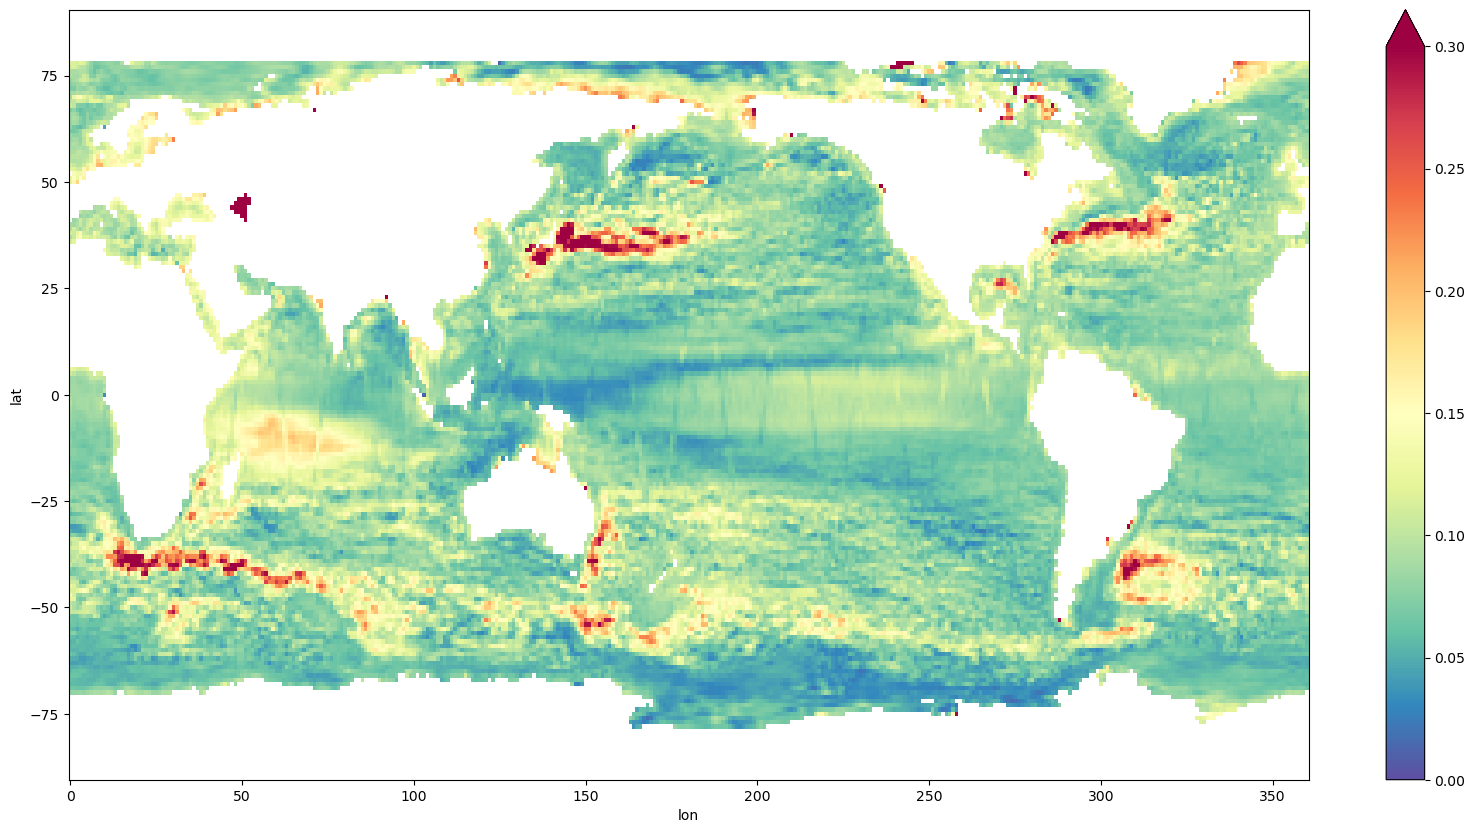

In [45]:
std_duacs.plot(cmap = 'Spectral_r', vmin = 0, vmax = 0.3, figsize = (20,10))

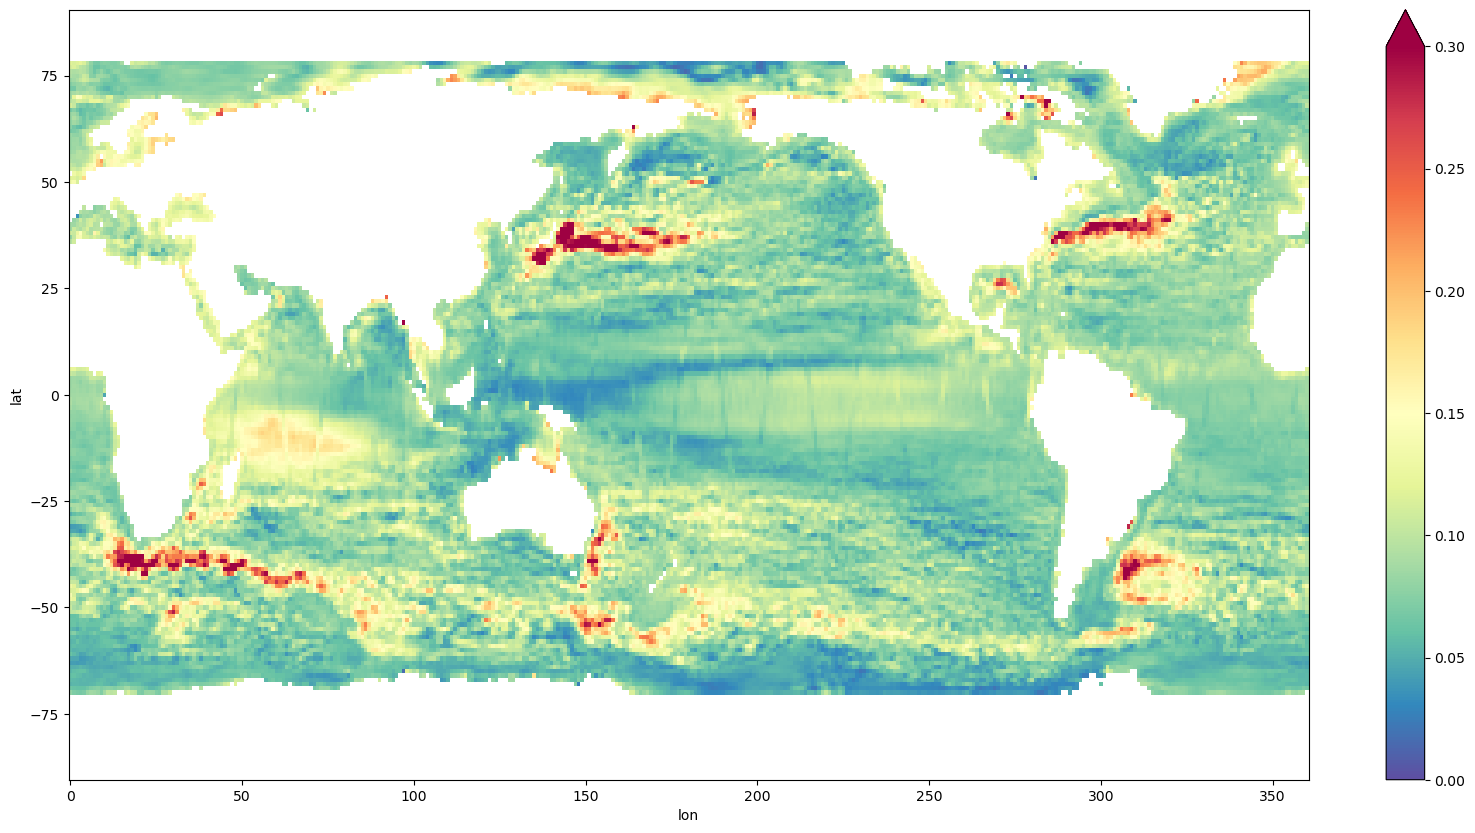

In [43]:
std_neurost.plot(cmap = 'Spectral_r', vmin = 0, vmax = 0.3, figsize = (20,10))

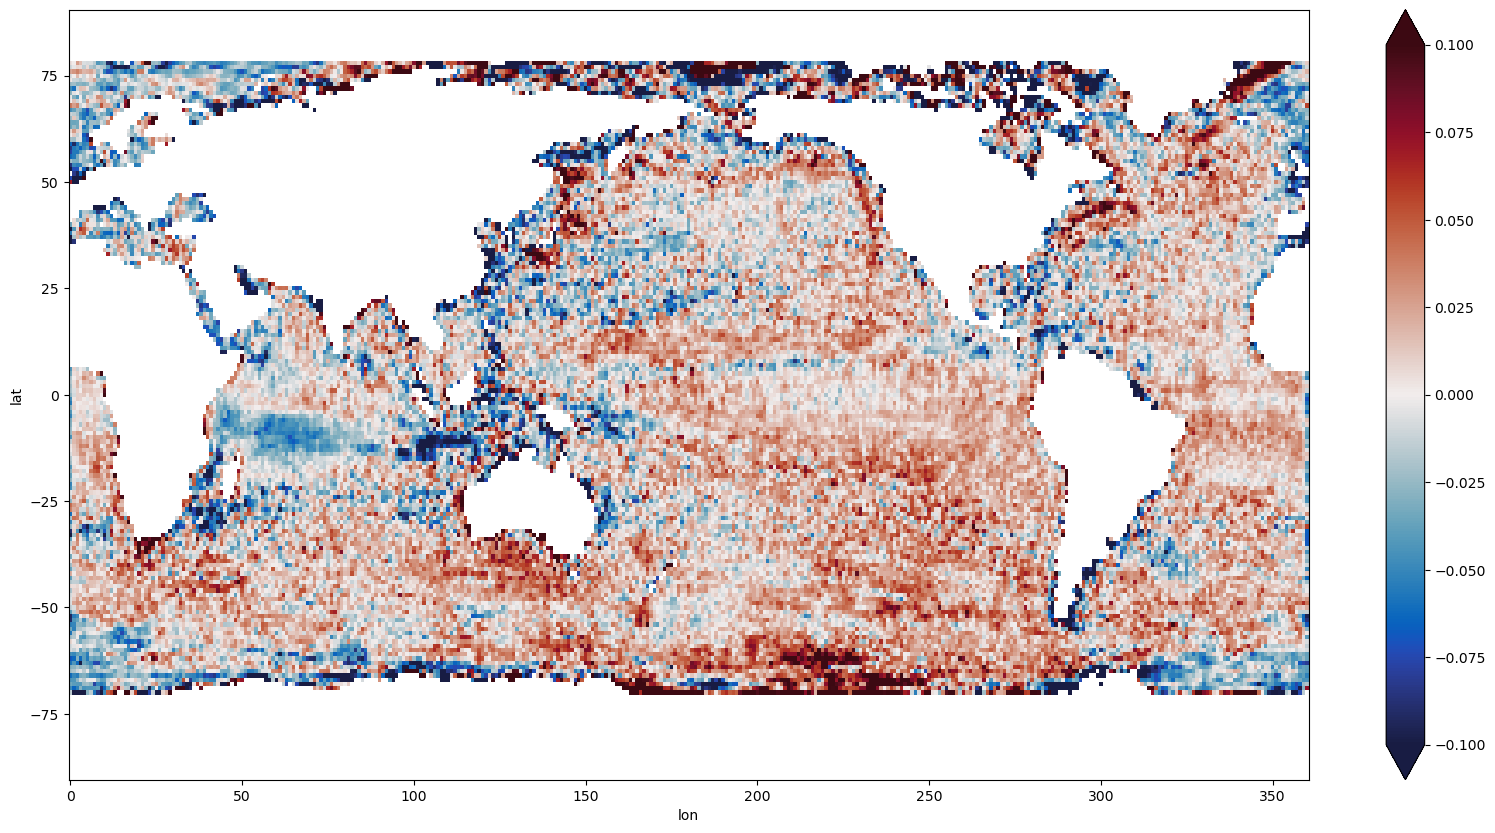

In [48]:
((std_neurost - std_duacs)/std_duacs).plot(cmap = cmocean.cm.balance, vmin = -0.1, vmax = 0.1, figsize = (20,10))

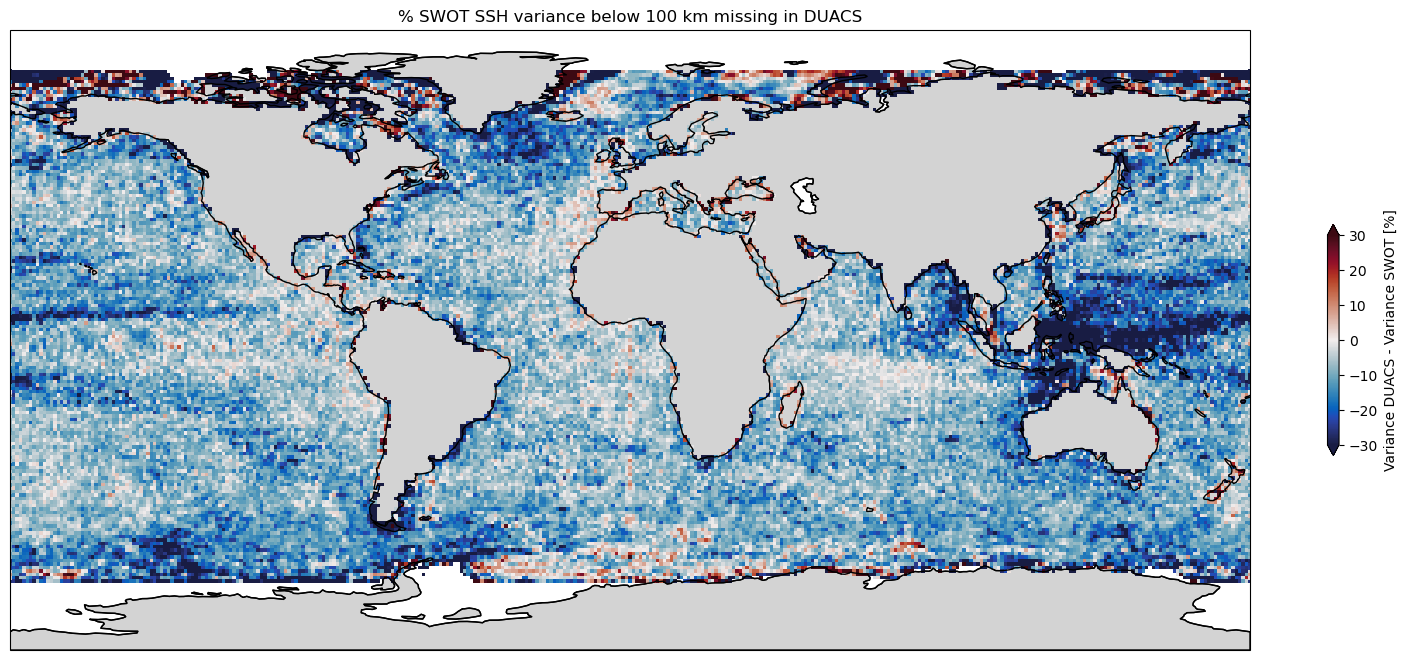

In [116]:
fig, axs = plt.subplots(1, 1, figsize=(20,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

plot_kwargs = dict(
    x="lon",
    y="lat",
    cmap=cmocean.cm.balance,
    vmin=-30,
    vmax=30,
    cbar_kwargs={"shrink": 0.3, 'label': 'Variance DUACS - Variance SWOT [%]'},)

# SWOT KaRIn SLA plots
(100 * (std_duacs**2 - std_swot**2)/std_swot**2).plot.pcolormesh(ax=axs, **plot_kwargs)

axs.coastlines()

# Shade land
axs.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
axs.set_title('% SWOT SSH variance below 100 km missing in DUACS')
fig.savefig('results/duacs_swot_missing_variance_filtered.png')

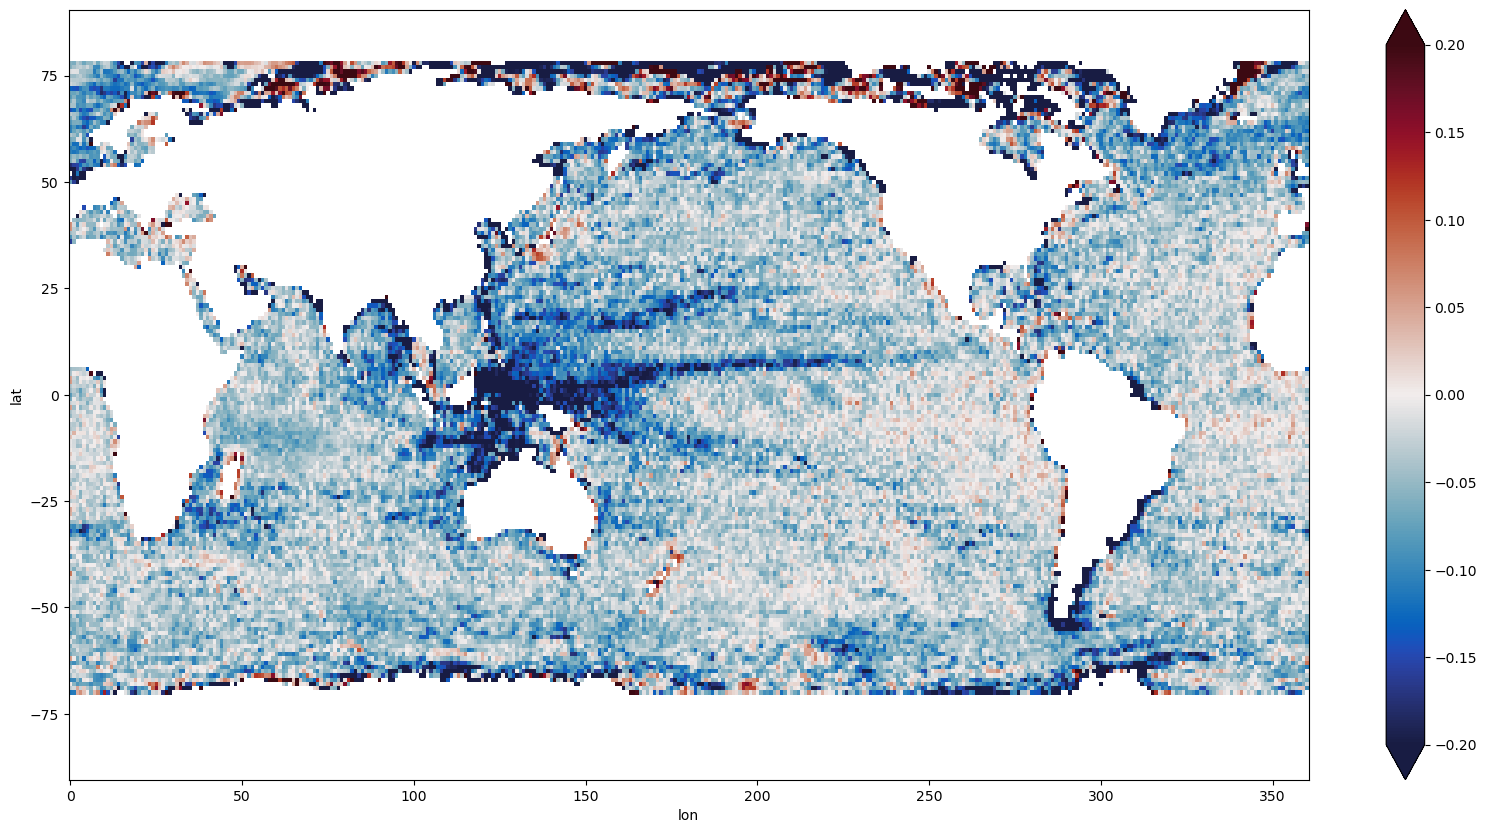

In [52]:


((std_neurost - std_swot)/std_swot).plot(cmap = cmocean.cm.balance, vmin = -0.2, vmax = 0.2, figsize = (20,10))

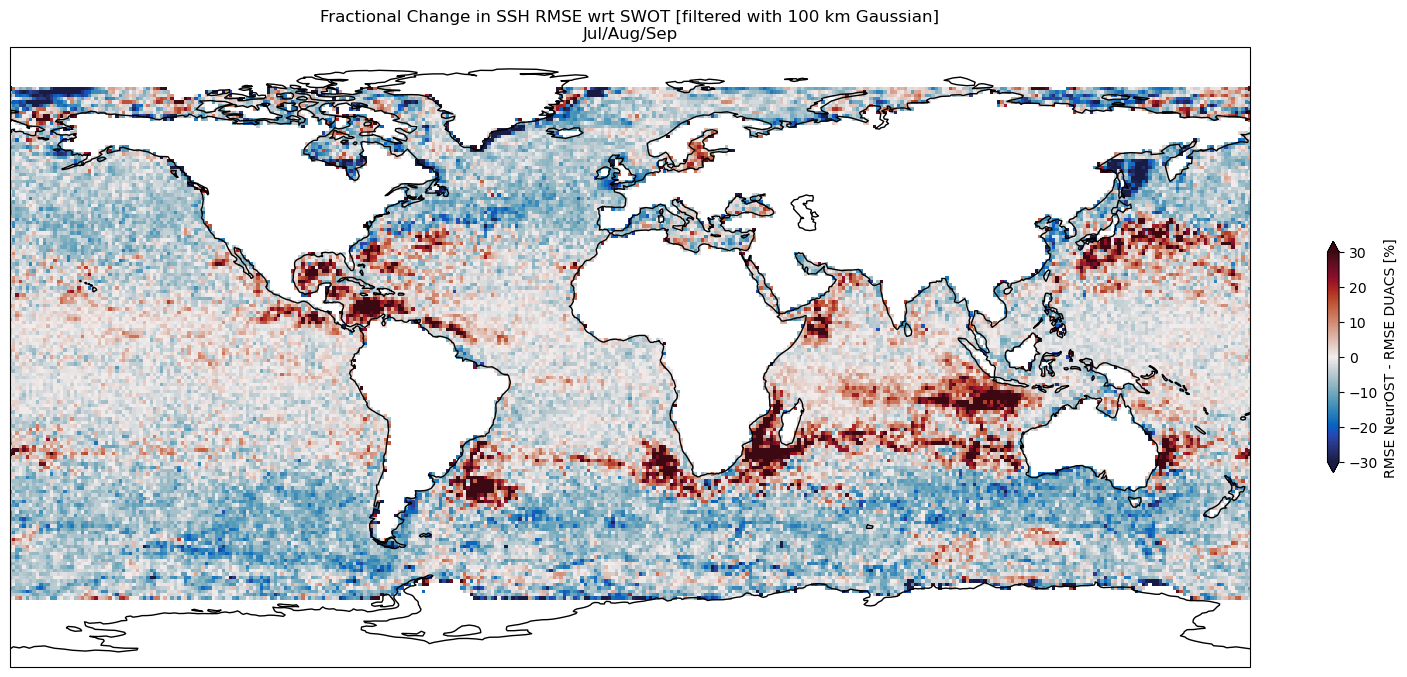

In [39]:
fig, axs = plt.subplots(1, 1, figsize=(20,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

plot_kwargs = dict(
    x="lon",
    y="lat",
    cmap=cmocean.cm.balance,
    vmin=-30,
    vmax=30,
    cbar_kwargs={"shrink": 0.3, 'label': 'RMSE NeurOST - RMSE DUACS [%]'},)

# SWOT KaRIn SLA plots
(100 * (rmse_neurost - rmse_duacs)/rmse_duacs).plot.pcolormesh(ax=axs, **plot_kwargs)

axs.coastlines()
axs.set_title('Fractional Change in SSH RMSE wrt SWOT [filtered with 100 km Gaussian]\nJul/Aug/Sep')
fig.savefig('results/neurost_duacs_swot_rmse_100km_filt_jas.png')

In [148]:
rmse_neurost = np.sqrt((result['ssha_diff_sum_squares'].isel(time=slice(3,None)).sum(dim = 'time'))/(result['ssha_diff_count'].isel(time=slice(3,None)).sum(dim = 'time')))
rmse_duacs = np.sqrt((result_duacs['ssha_diff_sum_squares'].isel(time=slice(3,None)).sum(dim = 'time'))/(result_duacs['ssha_diff_count'].isel(time=slice(3,None)).sum(dim = 'time')))


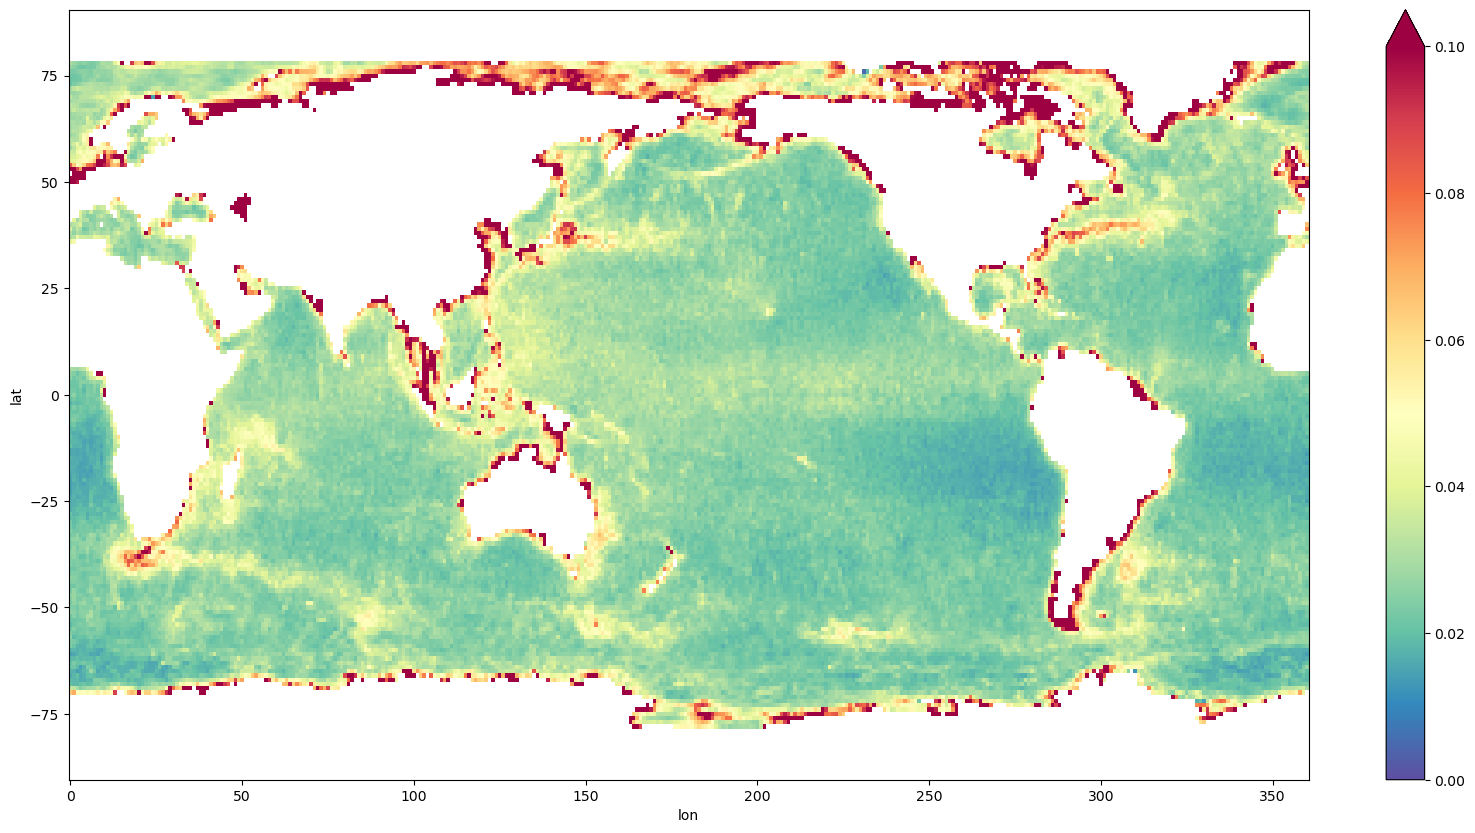

In [147]:
np.sqrt((result_duacs['ssha_diff_sum_squares'].isel(time=slice(3,None)).sum(dim = 'time'))/(result_duacs['ssha_diff_count'].isel(time=slice(3,None)).sum(dim = 'time'))).plot(figsize = (20,10), vmin = 0, vmax = 0.1, cmap ='Spectral_r')

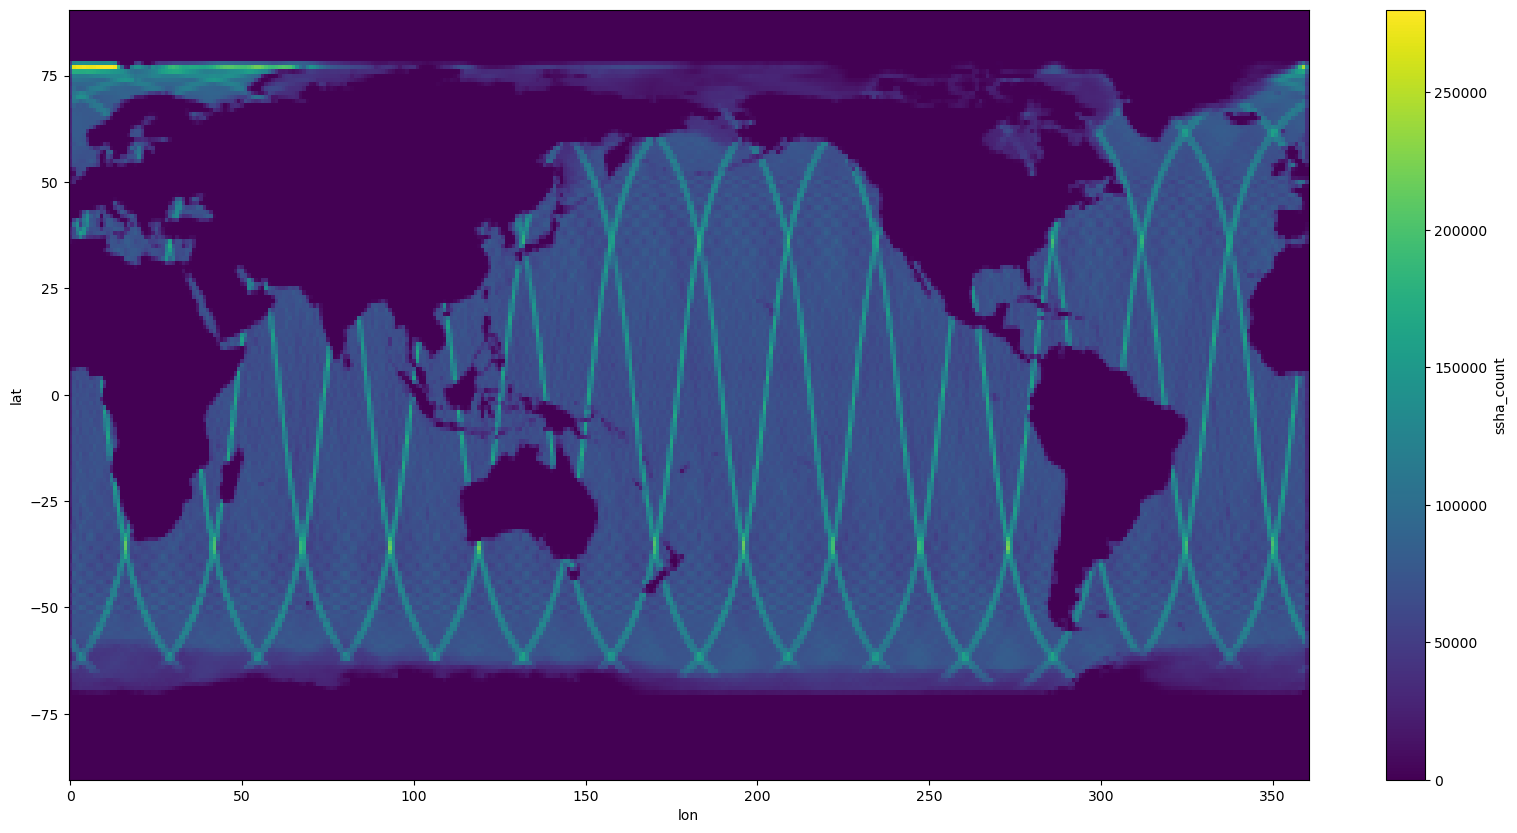

In [76]:
result['ssha_count'].sum(dim = 'time').plot(figsize = (20,10))

In [65]:
time_bin_size = int(7)

start_dt = np.datetime64('2023-03-28')
end_dt = np.datetime64('2024-09-16')

num_days = (((end_dt - start_dt)//time_bin_size).astype('timedelta64[D]') + 1).astype('int')

date_array = np.array([(start_dt + np.timedelta64(n * time_bin_size, 'D')).astype('datetime64[s]') for n in range(num_days)]) 

In [ ]:
for i, t in enumerate(date_array):
    start = t
    end = t + np.timedelta64(time_bin_size, 'D')
    print(f'start: {start}, end: {end}')

In [112]:
result.to_netcdf('results/NeurOST_SSH-SST_weekly_1deg_bins_ssh_rmse.nc')

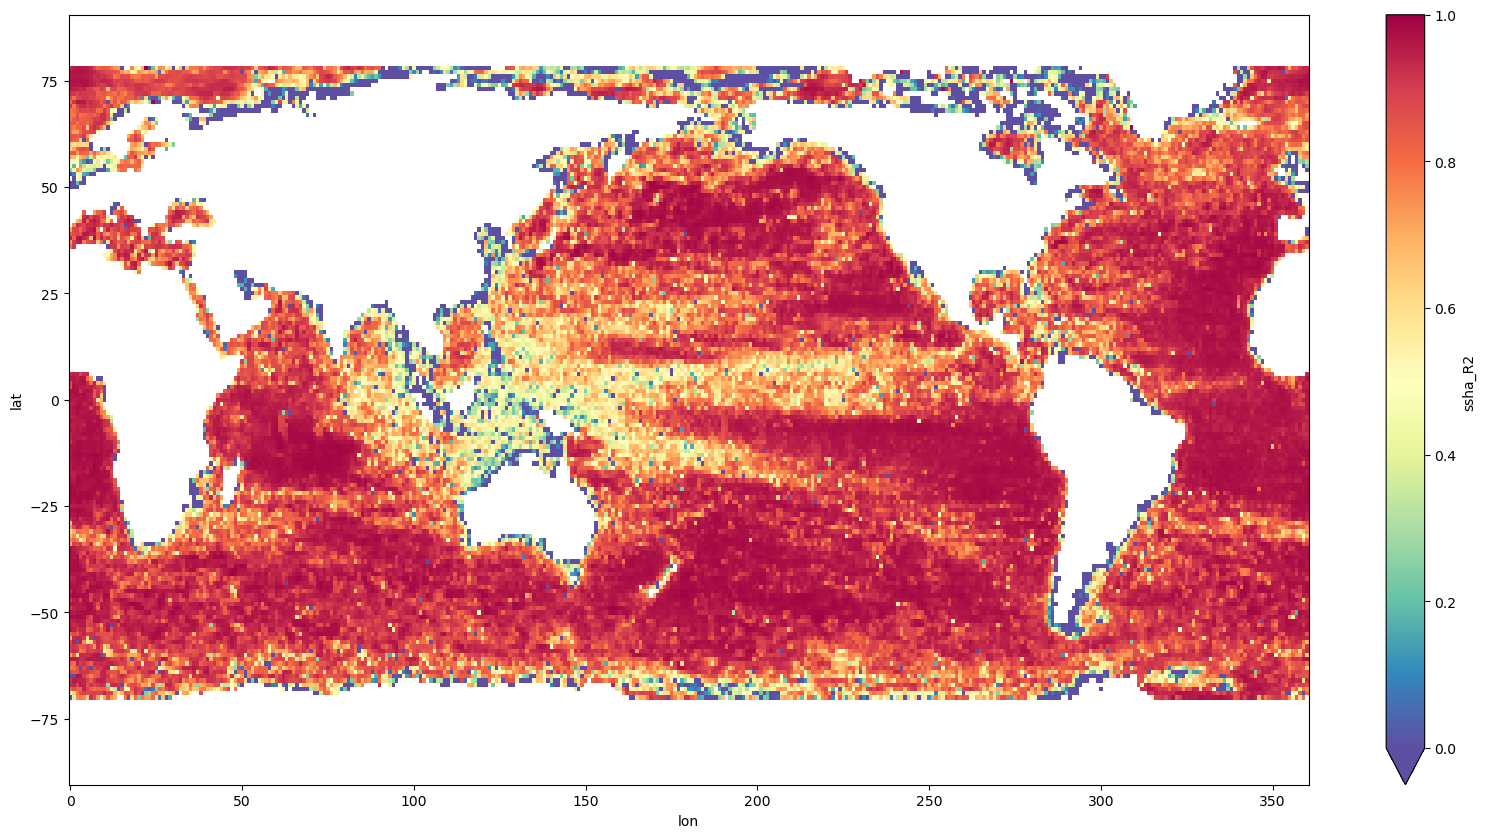

In [111]:
result['ssha_R2'].mean(dim='time').plot(vmin = 0, vmax = 1, cmap = 'Spectral_r', figsize = (20,10))

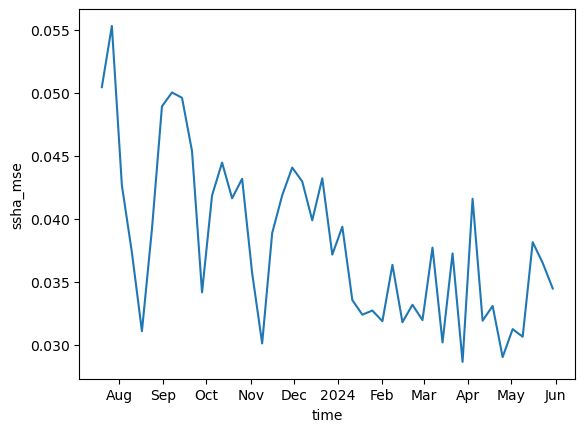

In [128]:
lon_min = 295
lon_max = 305
lat_min = 33
lat_max = 43
np.sqrt(result['ssha_mse']).sel(lon=slice(lon_min,lon_max), lat = slice(lat_min,lat_max)).mean(dim = ['lon', 'lat']).plot()
# np.sqrt(result['ssha_variance']).sel(lon=slice(lon_min,lon_max), lat = slice(lat_min,lat_max)).mean(dim = ['lon', 'lat']).plot()

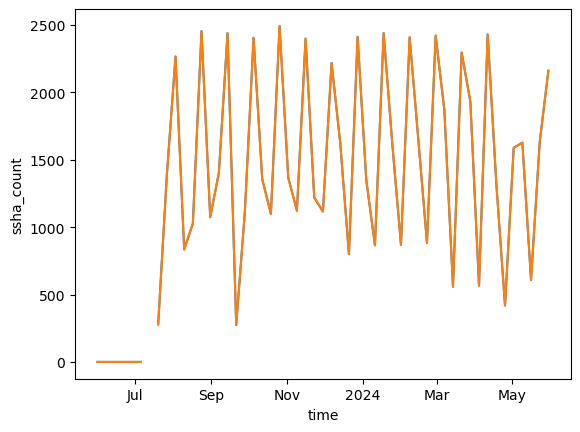

In [131]:
result['ssha_diff_count'].sel(lon=slice(lon_min,lon_max), lat = slice(lat_min,lat_max)).mean(dim = ['lon', 'lat']).plot()
result['ssha_count'].sel(lon=slice(lon_min,lon_max), lat = slice(lat_min,lat_max)).mean(dim = ['lon', 'lat']).plot()

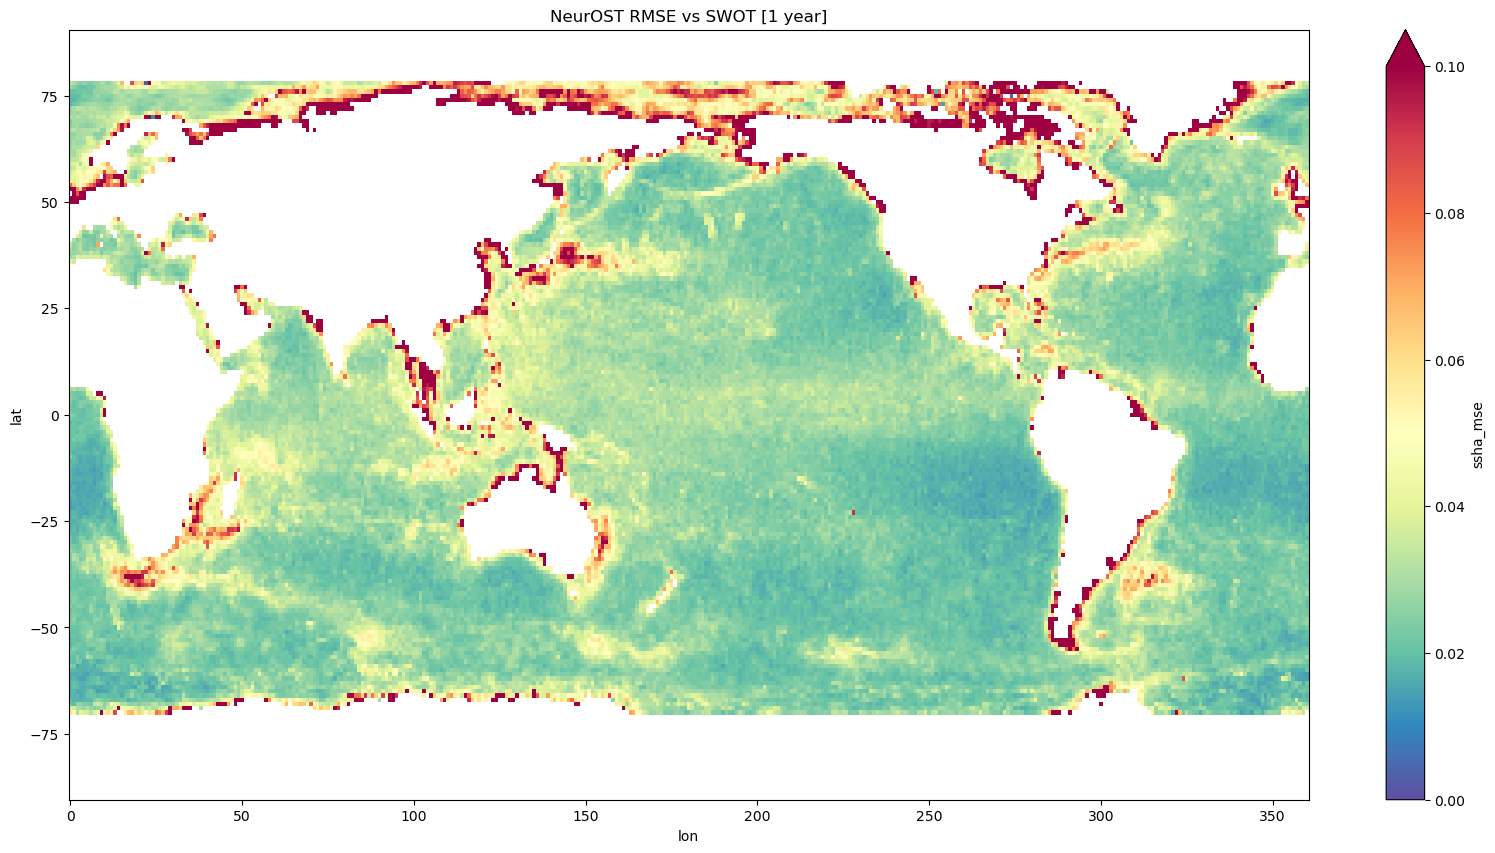

In [142]:
np.sqrt(result['ssha_mse'].isel(time=slice(3,None)).mean(dim = 'time')).plot(cmap = 'Spectral_r', vmin = 0, vmax = 0.1, figsize = (20,10))
plt.title('NeurOST RMSE vs SWOT [1 year]');

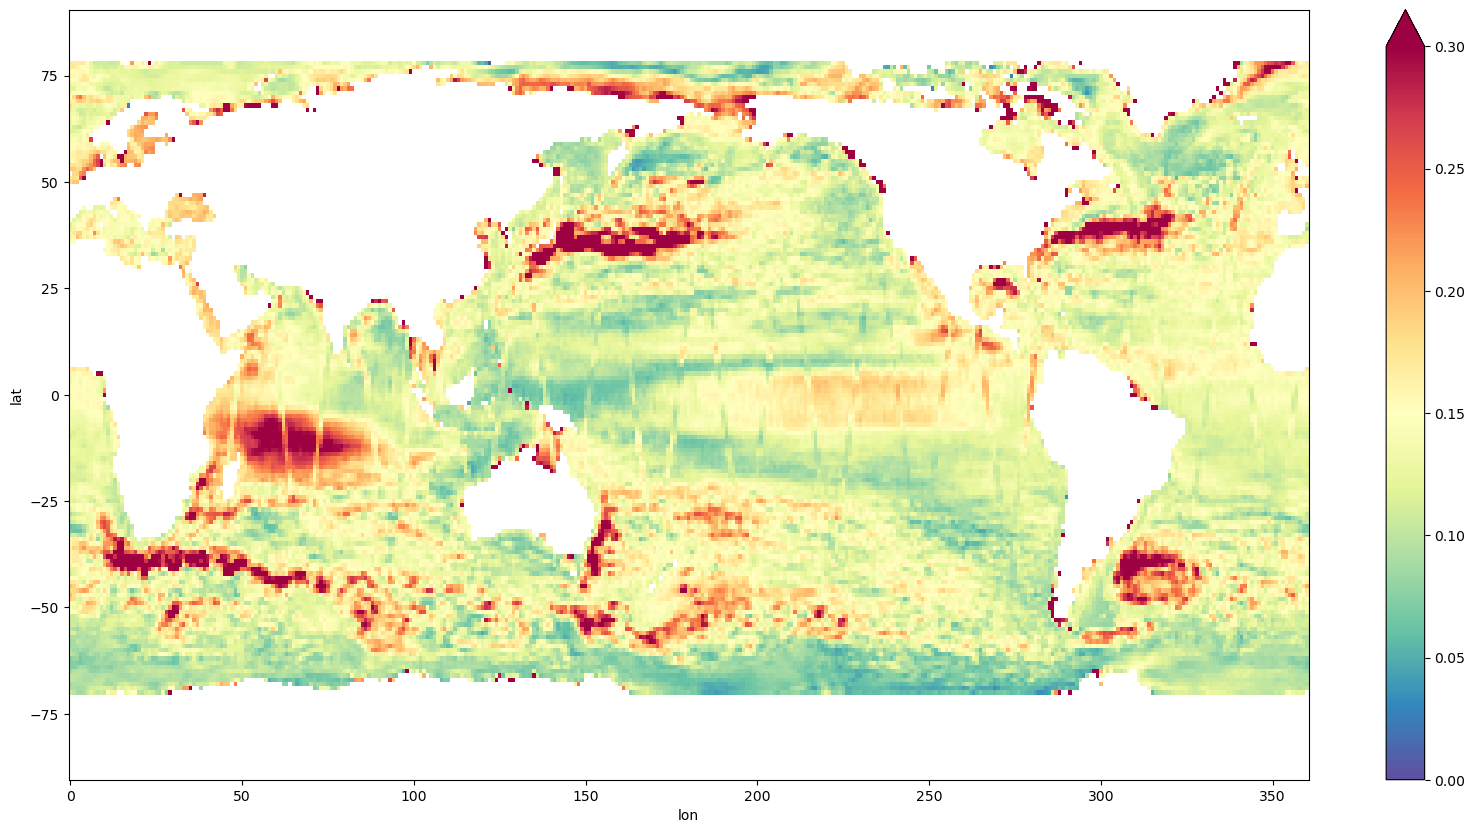

In [120]:
np.sqrt((result['ssha_sum_squares'].sum(dim='time')/result['ssha_count'].sum(dim = 'time'))).plot(cmap = 'Spectral_r', vmin = 0, vmax = 0.3, figsize = (20,10))


In [32]:
subset['sla_map'].plot(x='longitude', y = 'latitude')

Exception ignored in: Traceback (most recent call last):
'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
  File "/dat1/smart1n/miniconda3/envs/llc4320/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_237776/4025047785.py", line 1, in <module>
    subset['sla_map'].plot(x='longitude', y = 'latitude')
  File "/dat1/smart1n/miniconda3/envs/llc4320/lib/python3.12/site-packages/xarray/plot/accessor.py", line 48, in __call__
    return dataarray_plot.plot(self._da, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/dat1/smart1n/miniconda3/envs/llc4320/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py", line 270, in plot
    ).compute()
      ^^^^^^^^^
  File "/dat1/smart1n/miniconda3/envs/llc4320/lib/python3.12/site-packages/xarr

In [4]:
agg = spatial_aggregate(data = interp.ds, single_vars = ['sla_map', 'ssha'], pairwise_vars = [['ssha', 'sla_map']], lon_bin_size = 5, lat_bin_size = 5)

Binning: sla_map
Binning: ssha
Binning diff between: ssha and sla_map


In [7]:
stats = calculate_stats(agg, single_vars = ['sla_map', 'ssha'], pairwise_vars = [['ssha', 'sla_map']])

In [39]:
%%time
agg, stats = calc_aggregate_stats(data = interp.ds, single_vars = ['sla_map', 'ssha'], pairwise_vars = [['ssha', 'sla_map']], lon_bin_size = 1, lat_bin_size = 1)

Binning: sla_map
Binning: ssha
Binning diff between: ssha and sla_map
CPU times: user 1min 24s, sys: 1min 21s, total: 2min 46s
Wall time: 2min 44s


In [30]:
test = stats['ssha_R2'].values
test = test[~np.isnan(test)]
test[test!=0]

array([], dtype=float64)

In [3]:
subset = interp.subset(lon_min = 300, lon_max = 350, lat_min = 20, lat_max = 60)

In [4]:
swot

<xarray.Dataset> Size: 33MB
Dimensions:       (num_lines: 9245, num_pixels: 69)
Coordinates:
    latitude      (num_lines, num_pixels) float64 5MB 20.0 20.0 ... 19.8 19.8
    longitude     (num_lines, num_pixels) float64 5MB 344.1 344.1 ... 323.8
  * num_lines     (num_lines) int64 74kB 75064 75065 75066 ... 220736 220737
  * num_pixels    (num_pixels) int64 552B 0 1 2 3 4 5 6 ... 62 63 64 65 66 67 68
Data variables:
    ssha          (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9245, 69), meta=np.ndarray>
    mdt           (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9245, 69), meta=np.ndarray>
    time          (num_lines, num_pixels) datetime64[ns] 5MB dask.array<chunksize=(9245, 69), meta=np.ndarray>
    quality_flag  (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9245, 69), meta=np.ndarray>
    sla_map       (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9245, 69), meta=np.ndarray>
    adt_map       (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9245, 69), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0 (NASA/CNE...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    geospatial_lon_min:              168.765623
    geospatial_lon_max:              335.695073
    date_modified:                   2024-08-07T16:04:04Z
    history:                         2024-08-07T16:04:04Z: Created by DUACS K...
    date_created:                    2024-08-07T16:04:04Z
    date_issued:                     2024-08-07T16:04:04Z

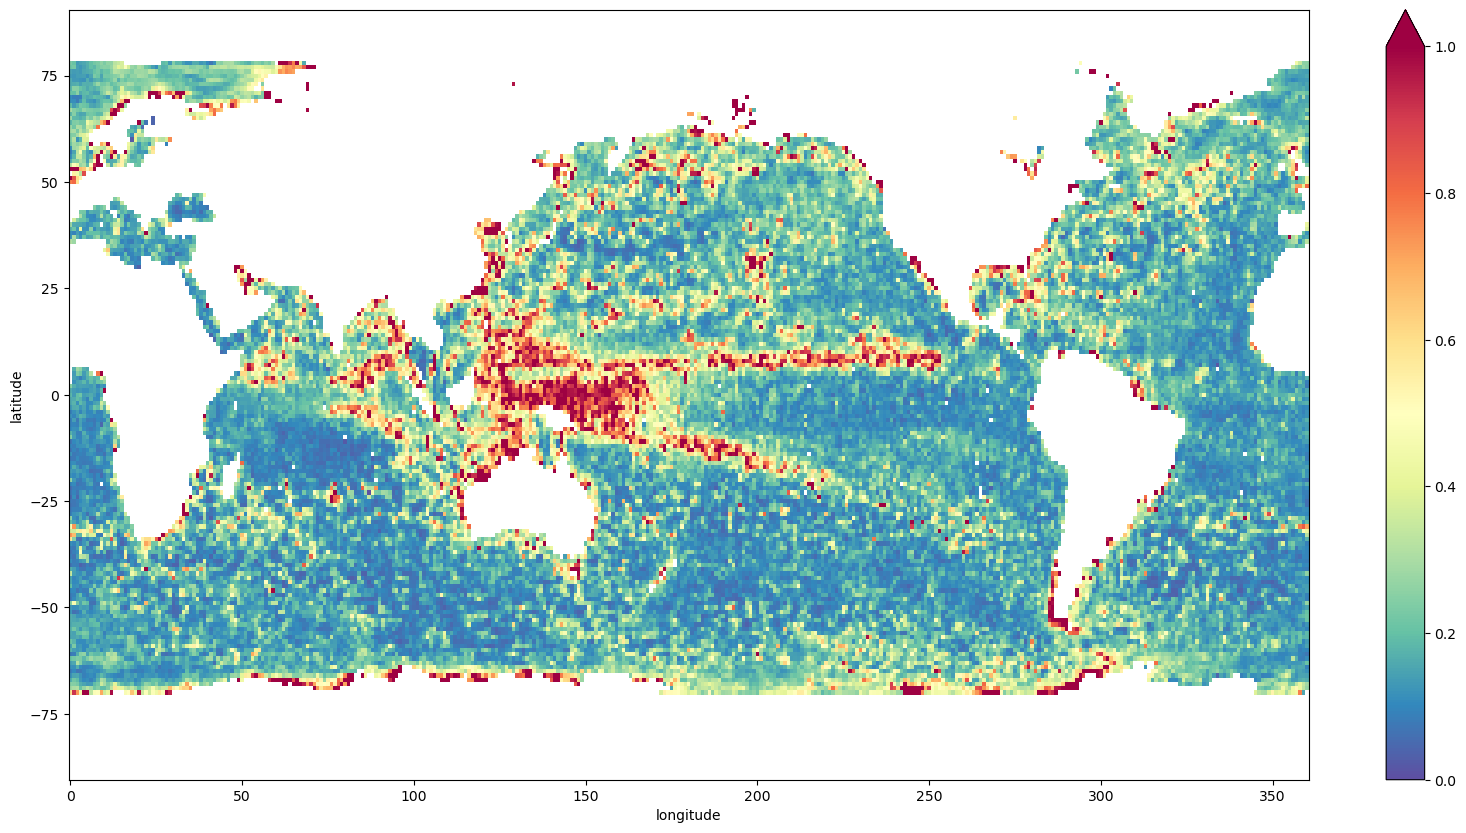

In [8]:
np.sqrt(stats['ssha_mse']/stats['ssha_variance']).plot(cmap='Spectral_r', vmin = 0, vmax = 1, figsize = (20,10))

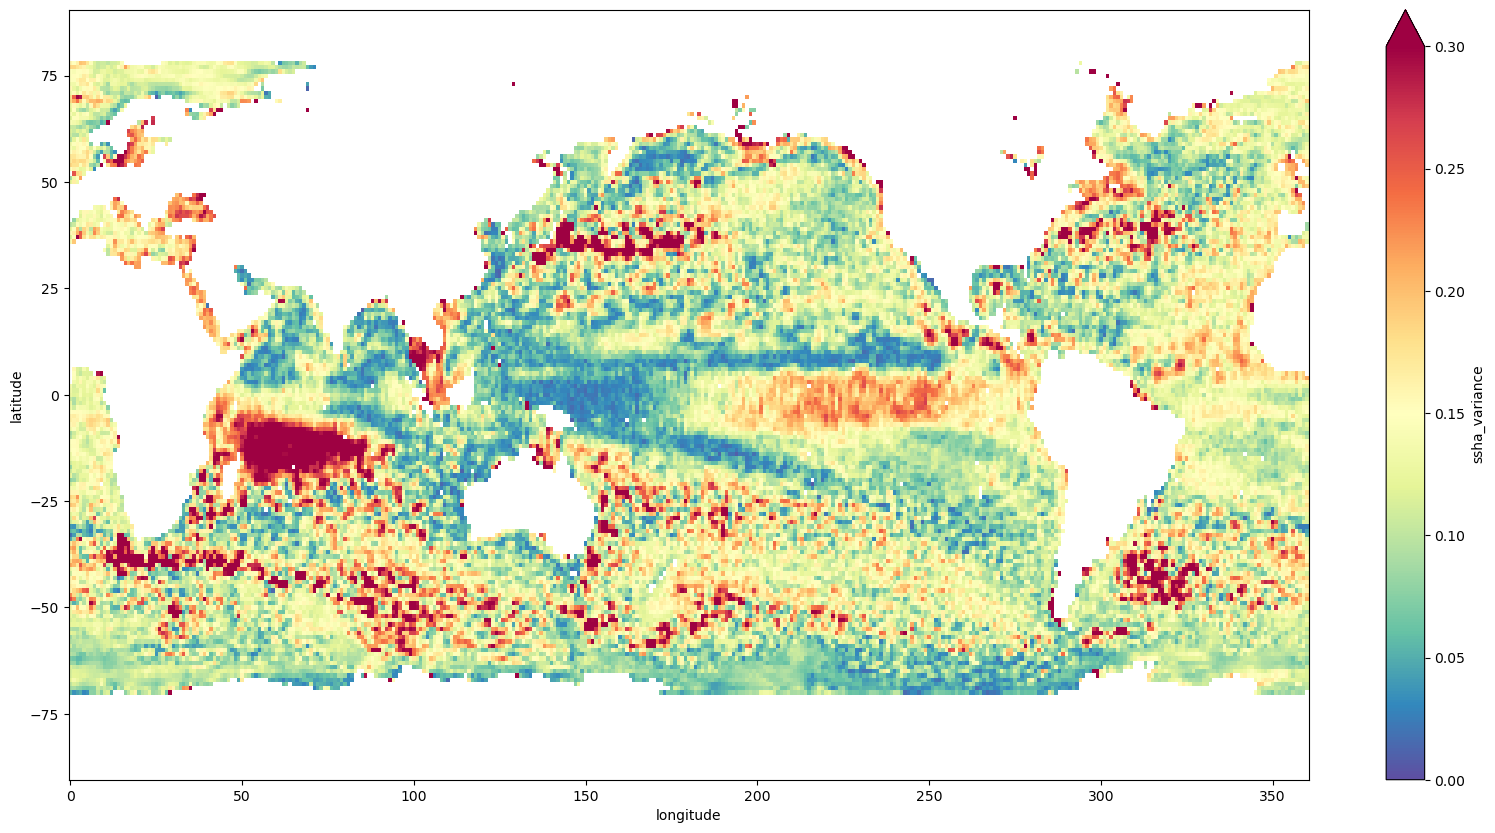

In [9]:
np.sqrt(stats['ssha_variance']).plot(cmap='Spectral_r', vmin = 0, vmax = 0.3, figsize = (20,10))

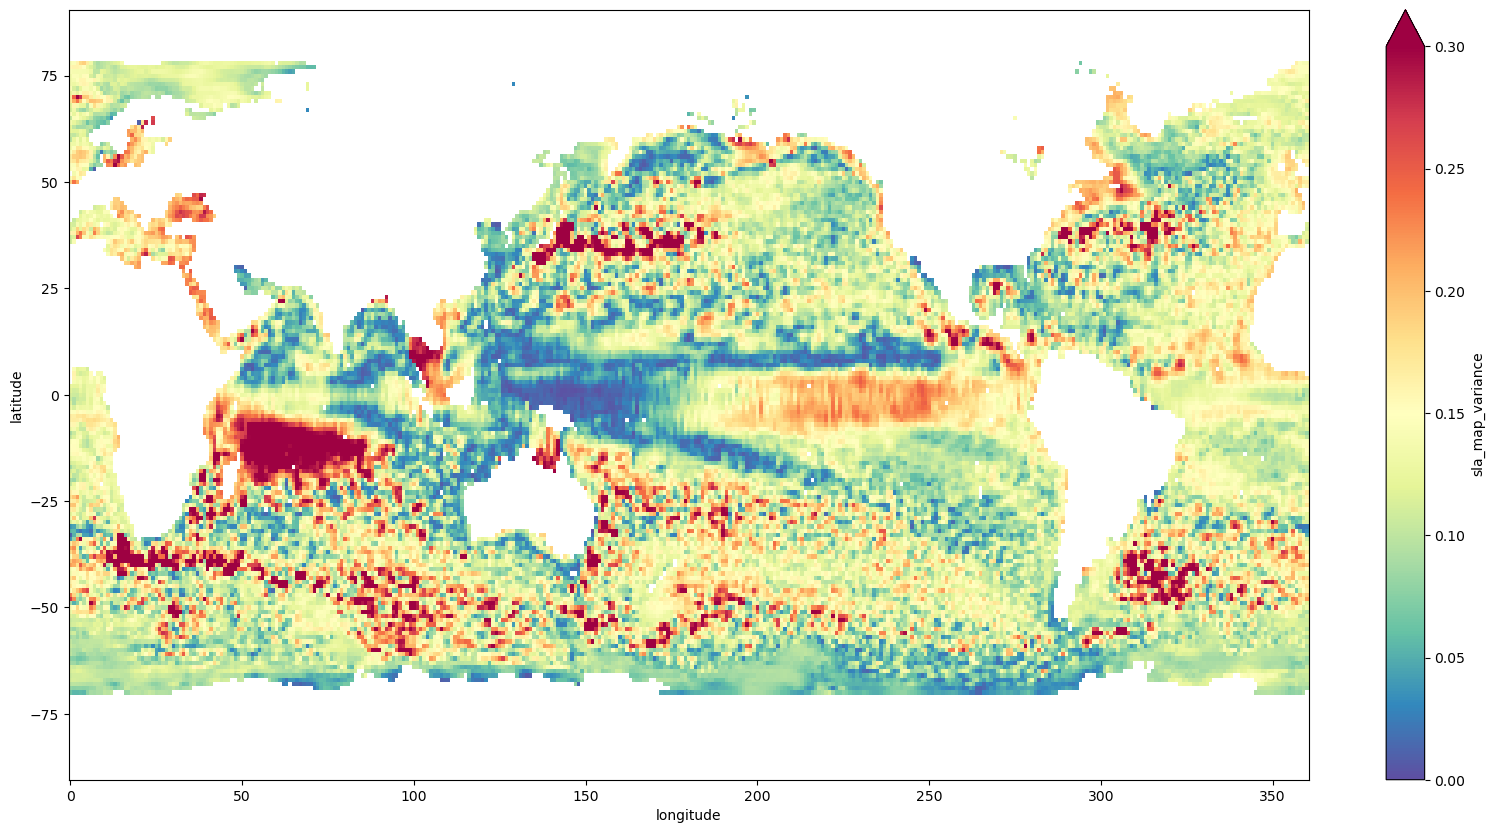

In [10]:
np.sqrt(stats['sla_map_variance']).plot(cmap='Spectral_r', vmin = 0, vmax = 0.3, figsize = (20,10))

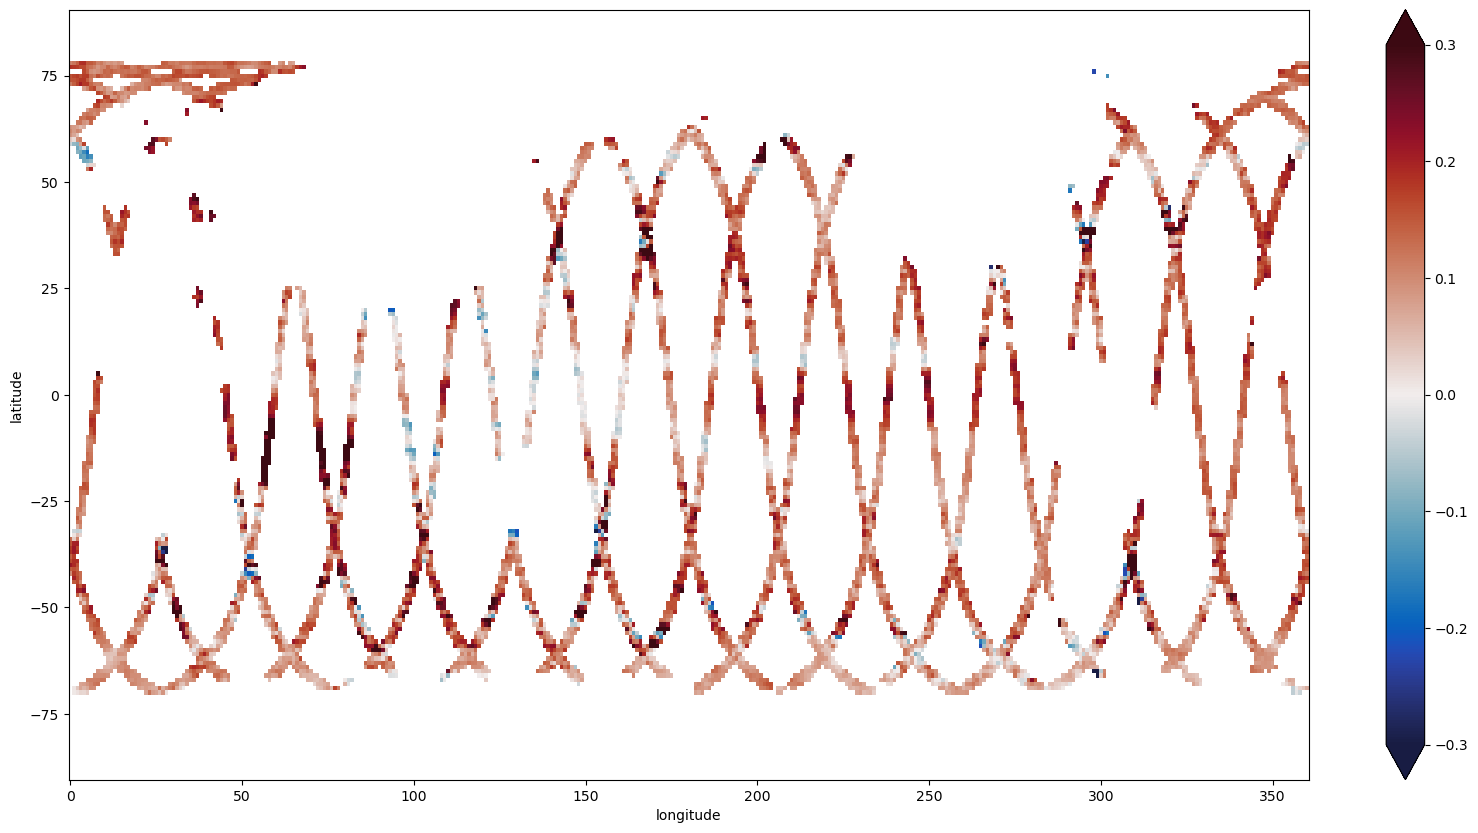

In [5]:
(agg['ssha_sum']/agg['ssha_count']).plot(cmap=cmocean.cm.balance, vmin = -0.3, vmax = 0.3, figsize = (20,10))

In [13]:
lon_bins = np.arange(0, 360 + 1, 1)
lat_bins = np.arange(-90, 90 + 1, 1)

In [20]:
lon_bins[-1]

360

In [19]:
agg['sla_map']['sum_squares'].shape

(361, 181)

/tmp/ipykernel_13304/216598781.py:1: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(lon_bins, lat_bins, np.sqrt((agg['sla_map']['sum_squares'].T) / (agg['sla_map']['count'].T)), cmap = cmocean.cm.amp, vmin = 0, vmax = 0.4)


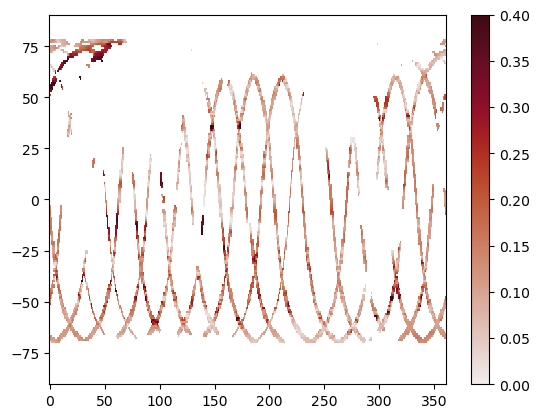

In [16]:
plt.pcolormesh(lon_bins, lat_bins, np.sqrt((agg['sla_map']['sum_squares'].T) / (agg['sla_map']['count'].T)), cmap = cmocean.cm.amp, vmin = 0, vmax = 0.4)
plt.colorbar()

/tmp/ipykernel_13304/2410140167.py:1: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(lon_bins, lat_bins, np.sqrt((agg['ssha']['sum_squares'].T) / (agg['ssha']['count'].T)), cmap = cmocean.cm.amp, vmin = 0, vmax = 0.4)


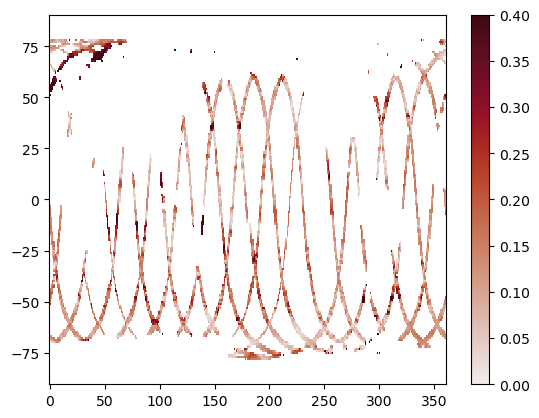

In [17]:
plt.pcolormesh(lon_bins, lat_bins, np.sqrt((agg['ssha']['sum_squares'].T) / (agg['ssha']['count'].T)), cmap = cmocean.cm.amp, vmin = 0, vmax = 0.4)
plt.colorbar()

In [37]:
start + np.timedelta64(1, 'M')

UFuncTypeError: Cannot cast ufunc 'add' input 1 from dtype('<m8[M]') to dtype('<m8[s]') with casting rule 'same_kind'

In [18]:
binning.push(ds['longitude'], ds['latitude'], ds['ssha'])

In [25]:
test = binning.variable('sum')

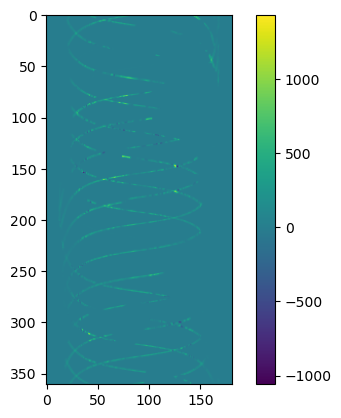

In [27]:
plt.imshow(test)
plt.colorbar()

In [13]:
ds = interp.ds.copy()



grouped_data = ds.groupby_bins(
    ('latitude', 'longitude'), bins=[lat_bins, lon_bins]
).sum(dim=('num_lines', 'num_pixels'))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [11]:
def aggregate_by_lon_lat_time(data, lon_bin_size, lat_bin_size, time_bin, lon_bounds = (0, 360), lat_bounds = (-90, 90)):
    """
    Aggregates data in an xarray dataset by longitude, latitude, and time bins.

    Args:
      data: xarray.Dataset containing the data to aggregate.
      lon_bin_size: The size of the longitude bins in degrees.
      lat_bin_size: The size of the latitude bins in degrees.
      time_bin: The time binning frequency (e.g., "1D").

    Returns:
      xarray.Dataset with aggregated data.
    """

    # Group by longitude and latitude bins using bin edges
    lon_bins = np.arange(lon_bounds[0], lon_bounds[1] + lon_bin_size, lon_bin_size)
    lat_bins = np.arange(lat_bounds[0], lat_bounds[1] + lat_bin_size, lat_bin_size)
    grouped_data = data.groupby(
      {
          "longitude": xr.DataArray(lon_bins, dims="lon_bin"),
          "latitude": xr.DataArray(lat_bins, dims="lat_bin"),
      }
    )

    # Resample by time and sum 'ssha'
    aggregated_data = (
      grouped_data.ssha.resample(time=time_bin).sum(dim="time")
    )

    # Create new coordinates for the aggregated data
    aggregated_data.coords["lon_center"] = (aggregated_data.longitude_bin.diff("lon_bin") / 2) + aggregated_data.longitude_bin
    aggregated_data.coords["lat_center"] = (aggregated_data.latitude_bin.diff("lat_bin") / 2) + aggregated_data.latitude_bin

    # Drop bin edges and rename dimensions
    aggregated_data = aggregated_data.drop_vars(["longitude_bin", "latitude_bin"])
    aggregated_data = aggregated_data.rename(
      {"lon_center": "longitude", "lat_center": "latitude"}
    )

    return aggregated_data

In [12]:
test = aggregate_by_lon_lat_time(interp.ds, lon_bin_size = 3, lat_bin_size = 3, time_bin = 1)

TypeError: `group` must be an xarray.DataArray or the name of an xarray variable or dimension. Received {'longitude': <xarray.DataArray (lon_bin: 121)> Size: 968B
array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,
        39,  42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,
        78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114,
       117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153,
       156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192,
       195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231,
       234, 237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270,
       273, 276, 279, 282, 285, 288, 291, 294, 297, 300, 303, 306, 309,
       312, 315, 318, 321, 324, 327, 330, 333, 336, 339, 342, 345, 348,
       351, 354, 357, 360])
Dimensions without coordinates: lon_bin, 'latitude': <xarray.DataArray (lat_bin: 61)> Size: 488B
array([-90, -87, -84, -81, -78, -75, -72, -69, -66, -63, -60, -57, -54,
       -51, -48, -45, -42, -39, -36, -33, -30, -27, -24, -21, -18, -15,
       -12,  -9,  -6,  -3,   0,   3,   6,   9,  12,  15,  18,  21,  24,
        27,  30,  33,  36,  39,  42,  45,  48,  51,  54,  57,  60,  63,
        66,  69,  72,  75,  78,  81,  84,  87,  90])
Dimensions without coordinates: lat_bin} instead.

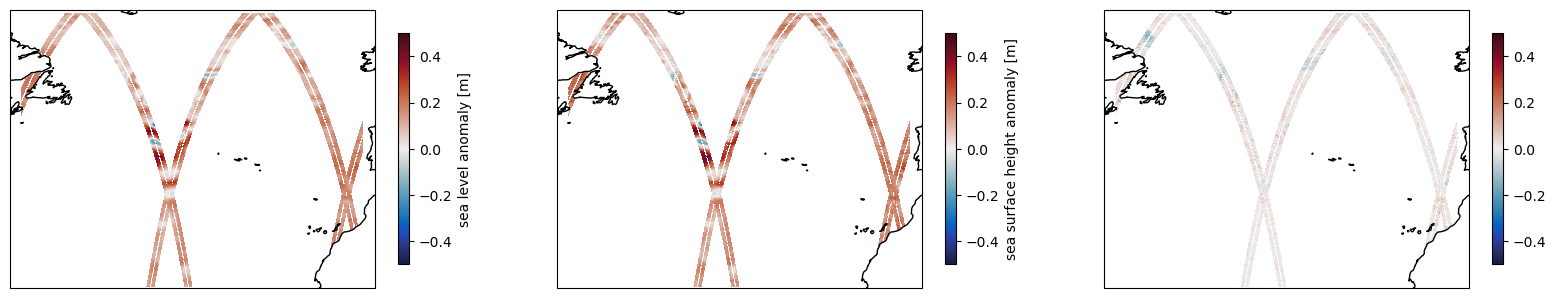

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap=cmocean.cm.balance,
    vmin=-0.5,
    vmax=0.5,
    cbar_kwargs={"shrink": 0.3},)

# SWOT KaRIn SLA plots
subset['sla_map'].plot.pcolormesh(ax=axs[0], **plot_kwargs)
subset['ssha'].plot.pcolormesh(ax=axs[1], **plot_kwargs)
(subset['ssha'] - subset['sla_map']).plot.pcolormesh(ax=axs[2], **plot_kwargs)

axs[0].coastlines()
axs[1].coastlines()
axs[2].coastlines()


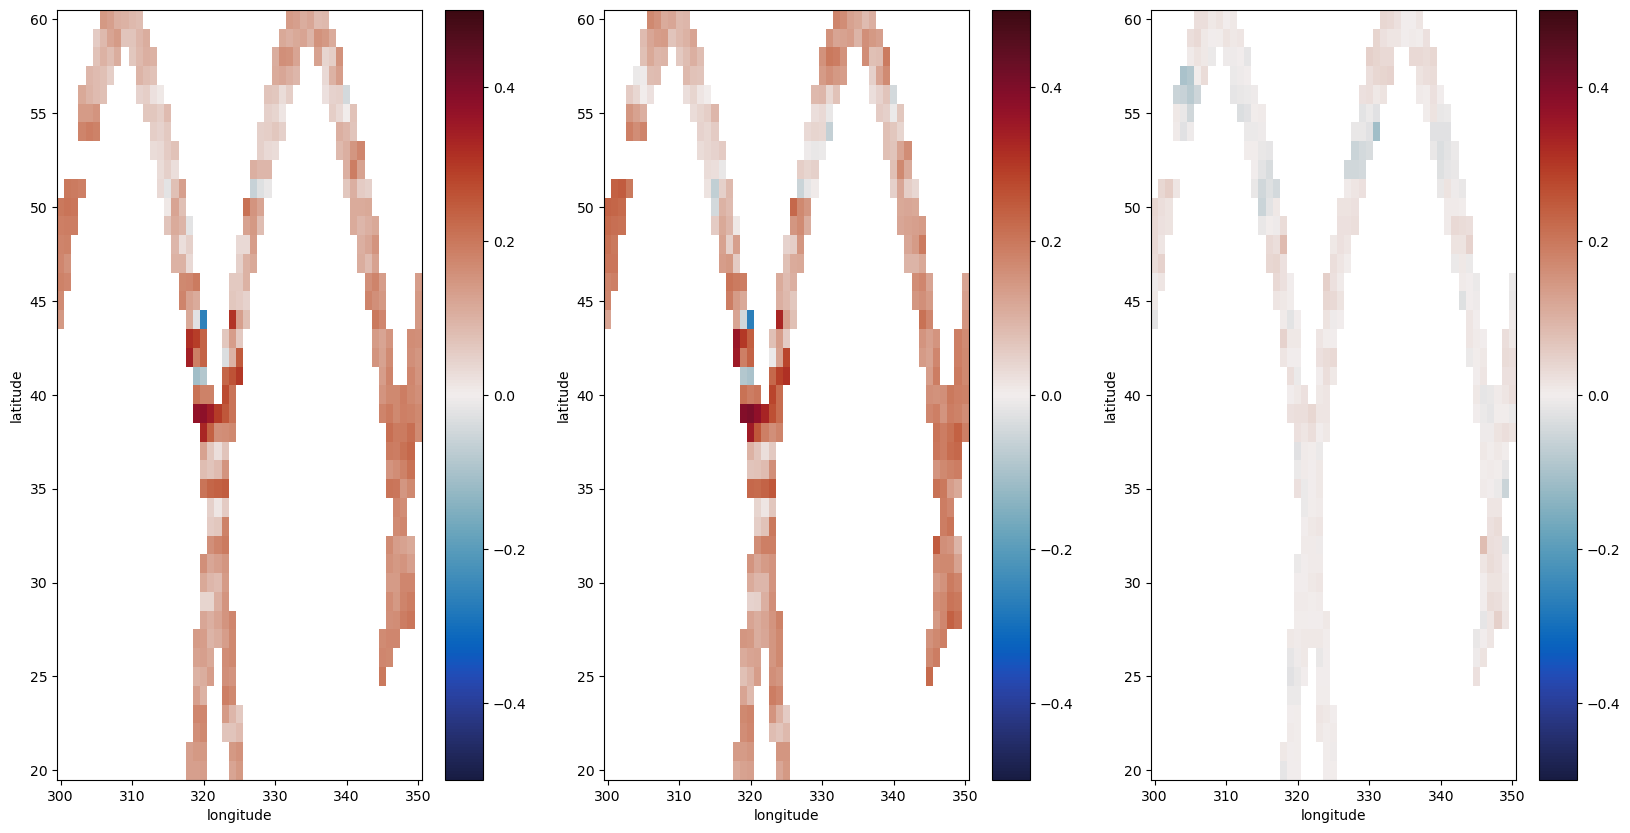

In [7]:
fig, axs = plt.subplots(1,3,figsize= (20,10))

(agg['sla_map_sum']/agg['sla_map_count']).sel(longitude = slice(300,350), latitude = slice(20,60)).plot(cmap = cmocean.cm.balance, vmin = -0.5, vmax = 0.5, ax = axs[0])
(agg['ssha_sum']/agg['ssha_count']).sel(longitude = slice(300,350), latitude = slice(20,60)).plot(cmap = cmocean.cm.balance, vmin = -0.5, vmax = 0.5, ax = axs[1])
(agg['ssha_diff_sum']/agg['ssha_diff_count']).sel(longitude = slice(300,350), latitude = slice(20,60)).plot(cmap = cmocean.cm.balance, vmin = -0.5, vmax = 0.5, ax = axs[2])


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap=cmocean.cm.balance,
    vmin=-0.5,
    vmax=0.5,
    cbar_kwargs={"shrink": 0.3},)

# SWOT KaRIn SLA plots
subset['sla_map'].plot.pcolormesh(ax=axs[0], **plot_kwargs)
subset['ssha'].plot.pcolormesh(ax=axs[1], **plot_kwargs)

axs[0].coastlines()
axs[1].coastlines()


In [50]:
str(start + np.timedelta64(2,'D'))[:10].replace('-','')

'20240127'

In [8]:
datadir = '/dat1/smart1n/NeurOST_SSH-SST/'
name_convention = {'prefix': 'NeurOST_SSH-SST_', 'date_hyphenated': False, 'suffix_format': '_YYYYMMDD.nc'}

files = sorted(os.listdir(datadir))
files = [f for f in files if '.nc' in f]
def extract_map_date(files, name_convention):
    return [f[len(name_convention['prefix']):-len(name_convention['suffix_format'])] for f in files]
map_date_strs = [f[len(name_convention['prefix']):-len(name_convention['suffix_format'])] for f in files]
map_datetimes = [str_to_datetime(f) for f in map_date_strs]

NameError: name 'str_to_datetime' is not defined

In [67]:
def str_to_datetime(string):
    return np.datetime64(string[:4] + '-' + string[4:6] + '-' + string[6:8] + "T00:00:00")

test = np.datetime64(map_date_strs[-1][:4] + '-' + map_date_strs[-1][4:6] + '-' + map_date_strs[-1][6:8] + "T00:00:00")
test

numpy.datetime64('2024-06-14T00:00:00')

In [13]:
data.ds

<xarray.Dataset> Size: 783MB
Dimensions:       (num_lines: 276080, num_pixels: 69)
Coordinates:
    latitude      (num_lines, num_pixels) float64 152MB 78.27 78.25 ... -78.27
    longitude     (num_lines, num_pixels) float64 152MB 97.26 97.26 ... 261.7
  * num_lines     (num_lines) int64 2MB 0 1 2 3 ... 276076 276077 276078 276079
  * num_pixels    (num_pixels) int64 552B 0 1 2 3 4 5 6 ... 62 63 64 65 66 67 68
Data variables:
    ssha          (num_lines, num_pixels) float64 152MB nan nan nan ... nan nan
    mdt           (num_lines, num_pixels) float64 152MB -0.1358 ... -1.109
    time          (num_lines, num_pixels) datetime64[ns] 152MB 2024-01-29T23:...
    quality_flag  (num_lines, num_pixels) uint8 19MB 102 100 100 ... 102 102 102
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    geospatial_lat_units:            degrees_north
    ...                              ...
    geospatial_lon_max:              264.188223
    date_modified:                   2024-08-07T07:34:54Z
    history:                         2024-08-07T07:34:54Z: Created by DUACS K...
    date_created:                    2024-08-07T07:34:54Z
    date_issued:                     2024-08-07T07:34:54Z
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0 (NASA/CNE...

In [113]:
lon_min = 130
lon_max = 170
lat_min = 15
lat_max = 45
# time_min = np.datetime64("2024-01-25T00:00:00")
# time_max = np.datetime64("2024-01-28T00:00:00")

subset = swot_data.subset(lon_min = lon_min, lon_max = lon_max, lat_min = lat_min, lat_max = lat_max)#, time_min = time_min, time_max = time_max)

In [111]:
subset.ds

<xarray.Dataset> Size: 32MB
Dimensions:                 (num_lines: 5494, num_pixels: 69)
Coordinates:
    latitude                (num_lines, num_pixels) float64 3MB 45.31 ... 44.99
    longitude               (num_lines, num_pixels) float64 3MB 166.1 ... 144.8
  * num_lines               (num_lines) int64 44kB 61547 61548 ... 234253 234254
  * num_pixels              (num_pixels) int64 552B 0 1 2 3 4 ... 64 65 66 67 68
Data variables:
    ssha                    (num_lines, num_pixels) float64 3MB nan nan ... nan
    mdt                     (num_lines, num_pixels) float64 3MB nan nan ... nan
    time                    (num_lines, num_pixels) datetime64[ns] 3MB NaT .....
    quality_flag            (num_lines, num_pixels) float32 2MB nan nan ... nan
    sla_map                 (num_lines, num_pixels) float64 3MB nan nan ... nan
    adt_map                 (num_lines, num_pixels) float64 3MB nan nan ... nan
    separation_along_track  (num_lines, num_pixels) float64 3MB nan ... 1.998...
    ssha_filtered           (num_lines, num_pixels) float64 3MB nan nan ... nan
    sla_map_filtered        (num_lines, num_pixels) float64 3MB nan nan ... nan
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0 (NASA/CNE...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    geospatial_lon_min:              168.765623
    geospatial_lon_max:              335.695073
    date_modified:                   2024-08-07T16:04:04Z
    history:                         2024-08-07T16:04:04Z: Created by DUACS K...
    date_created:                    2024-08-07T16:04:04Z
    date_issued:                     2024-08-07T16:04:04Z

In [14]:
(lon_min + 180)%360 - 180

-100

In [14]:
length = 50000
start = 0#50000
end = start + length
ds_basic = subset.isel(num_lines = slice(start, end))

In [27]:
data.ds.nbytes/1e9

4.671461492

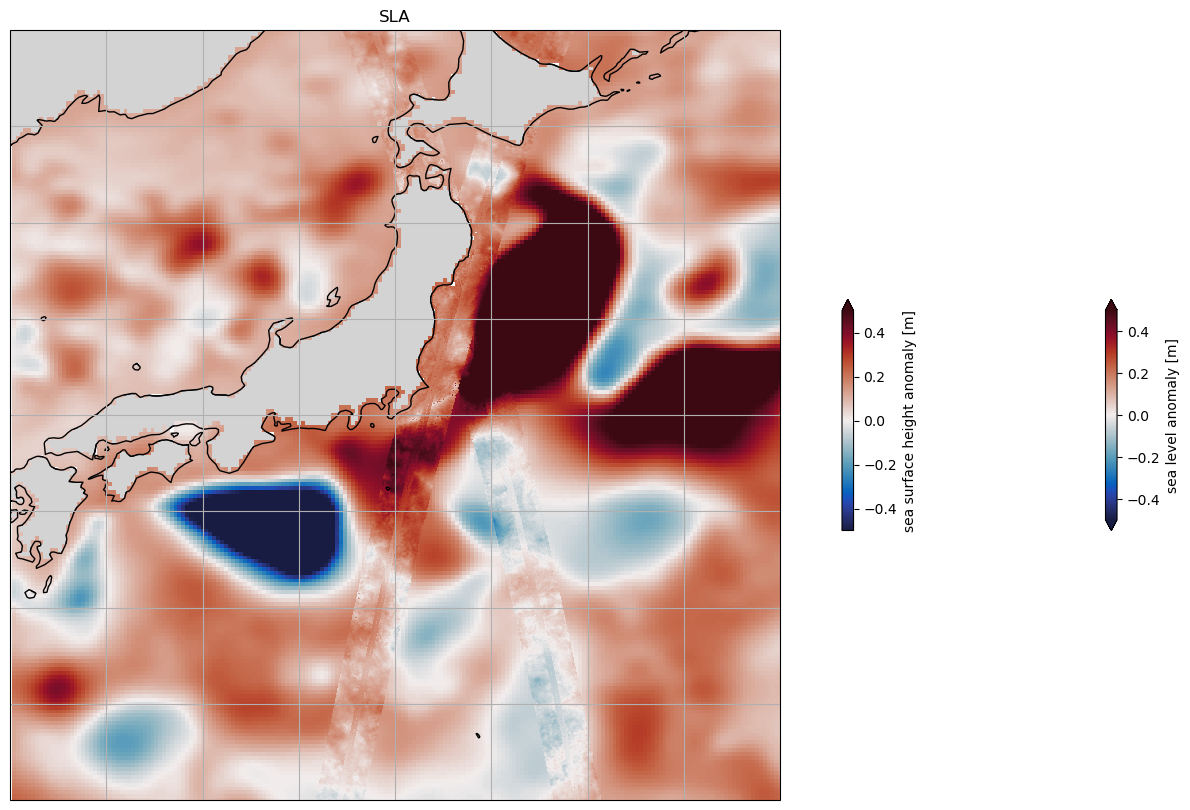

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(20,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap=cmocean.cm.balance,
    vmin=-0.5,
    vmax=0.5,
    cbar_kwargs={"shrink": 0.3},)

# SWOT KaRIn SLA plots
map_data.ds.sla.isel(time = 0).sel(longitude = slice(lon_min, lon_max), latitude = slice(lat_min, lat_max)).plot.pcolormesh(ax=ax, **plot_kwargs)
subset.ds.ssha.plot.pcolormesh(ax=ax, **plot_kwargs)

#
ax.set_title("SLA")
ax.coastlines()
ax.gridlines()
ax.set_xlim([(lon_min + 180)%360 - 180,(lon_max- 20 + 180)%360 - 180])
ax.set_ylim([lat_min + 10, lat_max])
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')


In [117]:
import zarr

In [124]:
d = zarr.open('/dat1/smart1n/SWOT_super_resolution/input_data/swot_karin_obs_swot_SR_SNP.zarr', mode = 'r')
d2 = zarr.open('/dat1/smart1n/SWOT_super_resolution/input_data/neurost_ssh-sst_SNP_1to6sats_v3.zarr', mode = 'r')
d2

<zarr.core.Array (418, 7, 66, 128, 128) float64 read-only>

In [127]:
mask = (d[0,31,]!=0)
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

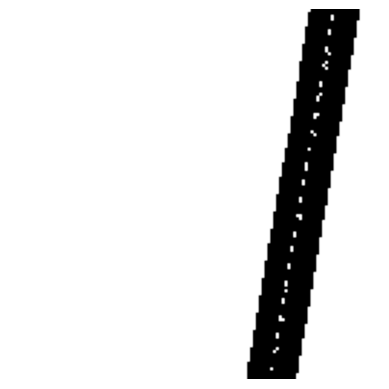

In [130]:
plt.imshow(mask, cmap = 'Greys', vmin = 0, vmax = 1)
plt.axis('off')
plt.savefig('/dat1/smart1n/swot_mask_snapshot.png')

In [5]:
files = sorted(os.listdir(datadir))
files = [f for f in files if '.nc' in f]

In [21]:
f = files[13909]
string = f[len(file_prefix):len(file_prefix)+15]
time = pd.to_datetime(string, format="%Y%m%dT%H%M%S", errors='coerce', yearfirst=True, utc=True)
d = np.datetime64(time)

/tmp/ipykernel_263328/946929258.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  d = np.datetime64(time)


In [8]:
file_prefix = 'SWOT_L3_LR_SSH_Expert_XXX_YYY_'

In [6]:
files[-1]

'SWOT_L3_LR_SSH_Expert_578_004_20230710T082100_20230710T091205_v1.0.2.nc'

In [22]:
file_prefix = 'SWOT_L3_LR_SSH_Expert_XXX_YYY_'
for i, f in enumerate(files):
    if i %100 == 0:
        print(i)
    string = f[len(file_prefix):len(file_prefix)+15]
    time = pd.to_datetime(string, format="%Y%m%dT%H%M%S", errors='coerce', yearfirst=True, utc=True)
    d = np.datetime64(time)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900


/tmp/ipykernel_263328/1323566135.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  d = np.datetime64(time)


In [8]:
time = pd.to_datetime(string, format="%Y%m%dT%H%M%S", errors='coerce', yearfirst=True, utc=True)
np.datetime64(time)

/tmp/ipykernel_261373/2990920621.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  np.datetime64(time)


numpy.datetime64('2023-07-30T02:12:39.000000')